In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import tqdm

import torch
import torch_geometric.data

from utils import plot_gel_conds, compare_gel_conds

from sklearn.metrics.pairwise import cosine_similarity
from similarity import calculate_tanimoto_similarity, get_zeolite_similarity, maximum_mean_discrepancy, visualize_smiles

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(f'ZeoSynGen_dataset.pkl', 'rb') as f: # load scaler
    dataset = pickle.load(f)

In [3]:
# def plot_gel_conds(x_syn_ratio, label=None):
#     '''
#     Args:
#         x_syn_ratio: (pd.DataFrame) with columns of synthesis conditions
#         label: (str) label for the plot
#     '''
#     xlims = {'Si/Al': [-5,410],
#                 'Al/P': [-0.1,1.8],
#                 'Si/Ge': [-5,100],
#                 'Si/B': [-10,260],
#                 'Na/T': [-0.2,2],
#                 'K/T': [-0.5,5.4],
#                 'OH/T': [-0.1,2.5],
#                 'F/T': [-0.05,1.3],
#                 'H2O/T': [-10,210],
#                 'sda1/T': [-0.3,7],
#                 'cryst_temp': [0,250],
#                 'cryst_time': [0,1000],
#                 }
#     fontsize = 15
#     fig = plt.figure(figsize=(6/3*len(x_syn_ratio.columns),3), dpi = 100)
#     col_idx = 1
#     for col_name in x_syn_ratio.columns:
#         ax = fig.add_subplot(1, len(x_syn_ratio.columns), col_idx)
#         sns.histplot(x_syn_ratio[col_name], label=label, bins=30, binrange=xlims[col_name])
        
#         ax.yaxis.set_tick_params(labelleft=False)
#         plt.xlim(*xlims[col_name])
#         plt.xlabel(col_name, fontsize=fontsize)
#         if col_idx > 1:
#             plt.ylabel('')
#         else:
#             plt.ylabel('Density', fontsize=fontsize)
#         col_idx += 1
#     plt.legend()
#     plt.show()

# def compare_gel_conds(x_syn_ratio1, x_syn_ratio2):
#     '''
#     Args:
#         x_syn_ratio1: (pd.DataFrame) with columns of synthesis conditions
#         x_syn_ratio2: (pd.DataFrame) with columns of synthesis conditions
        
#     '''
#     fontsize = 15
#     fig = plt.figure(figsize=(6/3*len(x_syn_ratio1.columns),3), dpi = 100)
#     col_idx = 1
#     for col_name in x_syn_ratio1.columns:
#         ax = fig.add_subplot(1, len(x_syn_ratio1.columns), col_idx)
#         col_max = max(x_syn_ratio1[col_name].max(), x_syn_ratio2[col_name].max())
#         col_min = min(x_syn_ratio1[col_name].min(), x_syn_ratio2[col_name].min())

#         sns.histplot(x_syn_ratio1[col_name], label=f'OSDA 1 (N: {len(x_syn_ratio1)})', bins=20, binrange=[col_min, col_max], color = 'tab:blue', )
#         sns.histplot(x_syn_ratio2[col_name], label=f'OSDA 2 (N: {len(x_syn_ratio2)})', bins=20, binrange=[col_min, col_max], color = 'tab:orange')
        
#         ax.yaxis.set_tick_params(labelleft=False)
#         plt.xlabel(col_name, fontsize=fontsize)
#         if col_idx > 1:
#             plt.ylabel('')
#         else:
#             plt.ylabel('Density', fontsize=fontsize)
#         col_idx += 1
#     plt.legend()
#     plt.show()

In [4]:
# Get all datapoints from dataset object
all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=False, return_dataframe=True)
# all_datapoints = dataset.get_datapoints_by_index([x for x in range(len(dataset))], scaled=True, return_dataframe=True)

# Create DataFrame with all datapoints
df = all_datapoints[1]
df['zeo'] = all_datapoints[3]
df['osda'] = all_datapoints[13]
df

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
0,400.0,0.000000,99.0,250.0,0.0,0.05,0.250000,0.0,31.000006,0.200000,150.000000,504.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
1,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,7.500000,0.500000,175.000000,168.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
2,400.0,0.000000,99.0,250.0,0.0,0.12,0.270000,0.0,44.000000,0.150000,150.000000,144.000000,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
3,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,20.000000,0.000000,115.720856,660.165100,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
4,2.5,1.717997,99.0,250.0,0.0,0.00,2.285717,0.0,28.571430,1.142857,125.000000,72.000000,BPH,CC[N+](CC)(CC)CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,30.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,135.000000,558.916321,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23957,40.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,160.000000,240.032150,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23958,70.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,53.891212,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23959,100.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,193.911392,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3


In [5]:
# # Standard scaling - to be deleted
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# zeos = df['zeo']
# osdas = df['osda']
# df = pd.DataFrame(scaler.fit_transform(df.drop(columns=['zeo', 'osda'])), columns=dataset.ratio_names+dataset.cond_names)
# df['zeo'] = zeos
# df['osda'] = osdas
# df

# OSDA similarity

In [6]:
osda_sims, syn_sims = [], []
zeos, osda_refs, osda_srcs = [], [], []
for zeo, c in df['zeo'].value_counts().items():
    if zeo != 'Dense/Amorphous':
        print(zeo)
        df_zeo = df[df['zeo']==zeo]
        df_zeo = df_zeo.drop(columns=['zeo'])

        unique_osdas = list(df_zeo['osda'].value_counts().keys())
        print('n_syn:', c)
        print('n_osda:', len(unique_osdas))
        
        # osda_sims, syn_sims = [], []

        for ref_idx in range(len(unique_osdas)):
            osda_ref = unique_osdas[ref_idx] # Reference OSDA
            df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

            for src_idx in range(ref_idx): # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
                osda_src = unique_osdas[src_idx] # Source OSDA
                df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])

                # 1) OSDA SIMILARITY
                if (osda_ref == 'OSDA-free') or (osda_src == 'OSDA-free'):
                    osda_sim = 0.
                else:
                    osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

                # 2) SYNTHESIS SIMILARITY
                # 2A) Mean cosine similarity of all pairs of synthesis conditions
                syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
                syn_sim = syn_sim.mean() # scalar

                # 2B) Cosine similarity of mean synthesis conditions
                # syn_sim = cosine_similarity(df_zeo_osda_src.mean().values.reshape(1, -1), df_zeo_osda_ref.mean().values.reshape(1, -1))[0][0]


                # # 2C) Maximum Mean Discrepancy
                # syn_sim = maximum_mean_discrepancy(df_zeo_osda_src.values, df_zeo_osda_ref.values)

                osda_sims.append(osda_sim), syn_sims.append(syn_sim)
                zeos.append(zeo), osda_refs.append(osda_ref), osda_srcs.append(osda_src)
                
                # plot_gel_conds(df_zeo_osda_src, label='Current')
                # plot_gel_conds(df_zeo_osda_ref, label='Most \n freq. OSDA')
                # print()

        # # Plot OSDA vs synthesis similarity for specific zeolite
        # plt.figure(figsize=(5,5),dpi=100)
        # plt.scatter(osda_sims, syn_sims, alpha=0.1)
        # plt.xlabel('OSDA similarity')
        # plt.ylabel('Synthesis similarity')
        # plt.show()

MFI
n_syn: 2247
n_osda: 168
CHA
n_syn: 1419
n_osda: 93
BEA
n_syn: 1178
n_osda: 128
AFI
n_syn: 918
n_osda: 73
MTW
n_syn: 601
n_osda: 139
LTA
n_syn: 556
n_osda: 33
FAU
n_syn: 546
n_osda: 37
MOR
n_syn: 489
n_osda: 86
MWW
n_syn: 464
n_osda: 24
TON
n_syn: 377
n_osda: 35
AEL
n_syn: 347
n_osda: 15
FER
n_syn: 297
n_osda: 45
BEC
n_syn: 267
n_osda: 33
AEI
n_syn: 234
n_osda: 27
MTT
n_syn: 225
n_osda: 35
LEV
n_syn: 225
n_osda: 25
ANA
n_syn: 220
n_osda: 48
UTL
n_syn: 219
n_osda: 20
SOD
n_syn: 210
n_osda: 26
AEN
n_syn: 207
n_osda: 27
GIS
n_syn: 200
n_osda: 22
ISV/BEC
n_syn: 197
n_osda: 7
MEL
n_syn: 187
n_osda: 32
NON
n_syn: 186
n_osda: 53
STF
n_syn: 182
n_osda: 46
MRE
n_syn: 181
n_osda: 30
AST
n_syn: 147
n_osda: 38
ITH
n_syn: 144
n_osda: 2
EMT
n_syn: 143
n_osda: 9
IWR
n_syn: 140
n_osda: 8
ATO
n_syn: 134
n_osda: 8
ITQ-21
n_syn: 131
n_osda: 7
ERI
n_syn: 127
n_osda: 27
DDR
n_syn: 121
n_osda: 15
EUO
n_syn: 116
n_osda: 12
STW
n_syn: 114
n_osda: 13
MAZ
n_syn: 113
n_osda: 8
STO
n_syn: 112
n_osda: 27
RTH
n_

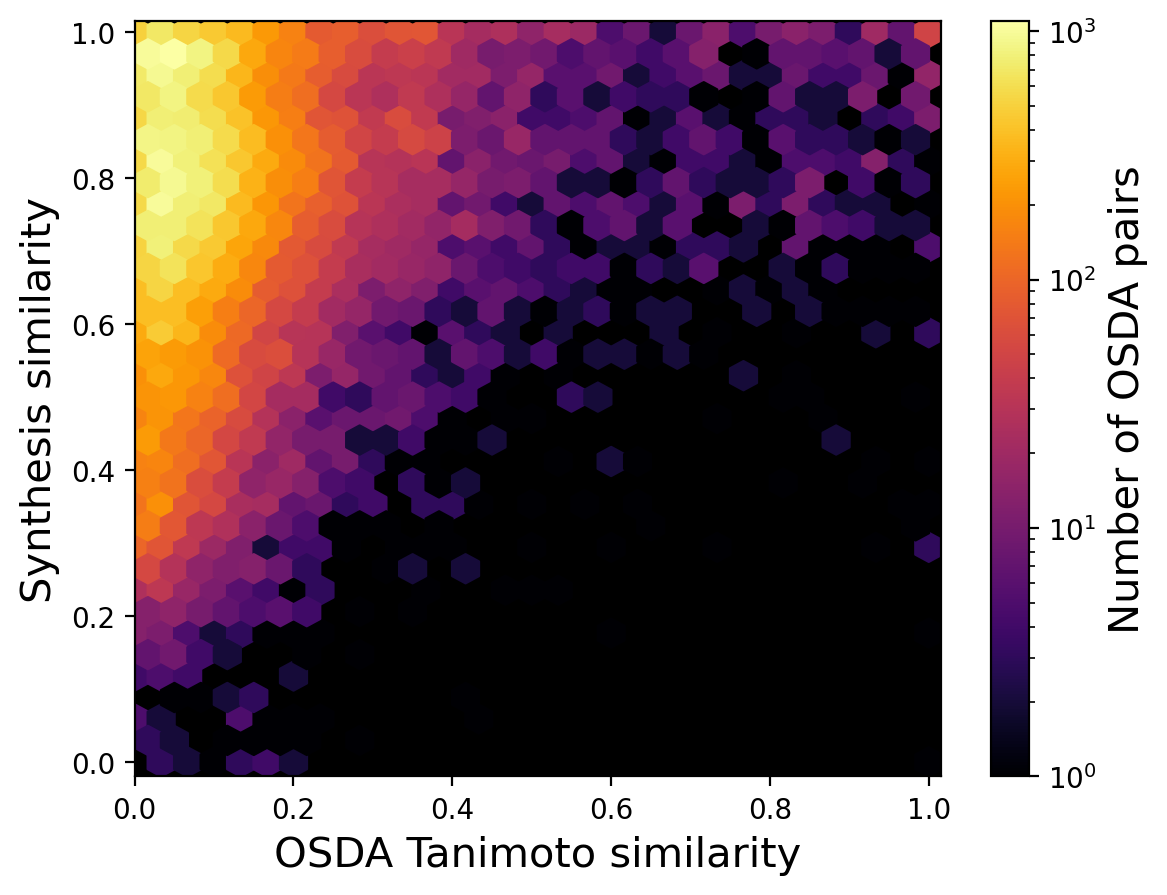

In [7]:
plt.figure(figsize=(6.5,5),dpi=200)
plt.hexbin(osda_sims, syn_sims, gridsize=30, mincnt=0, bins='log', cmap='inferno', facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.xlabel('OSDA Tanimoto similarity', fontsize=15)
plt.ylabel('Synthesis similarity', fontsize=15)
cb = plt.colorbar()
cb.set_label('Number of OSDA pairs', fontsize=15)
plt.xlim(-0.00,1.015)
plt.ylim(-0.02,1.015)
# plt.xlim(-0.00,1.02)
# plt.ylim(-0.01,2)
plt.show()

In [8]:
df_osda_sim = pd.DataFrame({'zeo': zeos, 'osda_ref': osda_refs, 'osda_src': osda_srcs, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
df_osda_sim

,zeo,osda_ref,osda_src,osda_sim,syn_sim
0,MFI,OSDA-free,CCC[N+](CCC)(CCC)CCC,0.000000,0.766919
1,MFI,CC[N+](CC)(CC)CC,CCC[N+](CCC)(CCC)CCC,0.333333,0.830895
2,MFI,CC[N+](CC)(CC)CC,OSDA-free,0.000000,0.729034
3,MFI,NCCCCCCN,CCC[N+](CCC)(CCC)CCC,0.047619,0.747379
4,MFI,NCCCCCCN,OSDA-free,0.000000,0.764694
...,...,...,...,...,...
56587,CHA/AEI,CCN(CC)CC,NCCNCCNCCNCCNCCN,0.045455,0.951450
56588,PWO,Cc1cc[n+](C)n1C,Cc1n(C)cc[n+]1C,0.310345,1.000000
56589,ASU-14,NCCN,C1CNCCN1,0.000000,0.921631
56590,SFN,C[N+]1(CC2(c3ccccc3)CCCC2)CCCCC1,C[N+]1(CC2(c3ccccc3)CCCC2)CCCCCCC1,0.930233,0.371408


In [9]:
df_osda_sim.sort_values('syn_sim', ascending=False)

,zeo,osda_ref,osda_src,osda_sim,syn_sim
50543,NON,CC(C)[N+](C)(C)C,C[N+](C)(C)C12CCC(CC1)C2,0.120000,1.0
24410,BEA,CC1C[N+]2(CCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,C(CCCC[N+]12CCN(CC1)CC2)CCC[N+]12CCN(CC1)CC2,0.285714,1.0
24505,BEA,CC1C[N+]2(CCCCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,CC1C[N+]2(CCCCCCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,0.968750,1.0
24521,BEA,CC1C[N+]2(CCCCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,CC1C[N+]2(CCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,0.875000,1.0
24395,BEA,CC1C[N+]2(CCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,CC1C[N+]2(CCCCCCCC[N+]34CCN(CC3)C(C)C4)CCN1CC2,0.848485,1.0
...,...,...,...,...,...
46106,AEI,CC[N+]1(CC)[C@@H](C)CCC[C@H]1C,CCn1cc[n+](C)c1,0.078947,0.0
46264,AEI,CC1CC[N+](C)(C)C2CC1C2(C)C,CC[N+]1(CC)[C@@H](C)CCC[C@H]1C,0.159091,0.0
56573,BSV,NCCN(CCN)CCN,[NH3+]CC[NH2+]CC[NH3+],0.043478,0.0
46311,AEI,C[C@H]1C[C@H](C)C[N+](C)(C)C1,CC[N+]1(CC)[C@@H](C)CCC[C@H]1C,0.156250,0.0


0
zeo: MOR
osda 1: CC[N+](CC)(CC)CCCCCCC[N+](CC)(CC)CC 9
osda 2: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 3
osda similarity: 1.0
synthesis similarity: 0.9996739


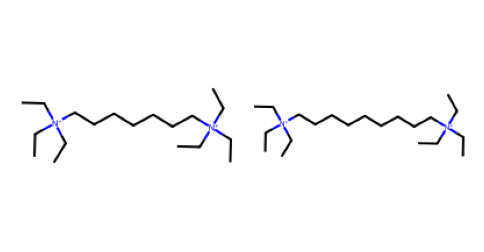

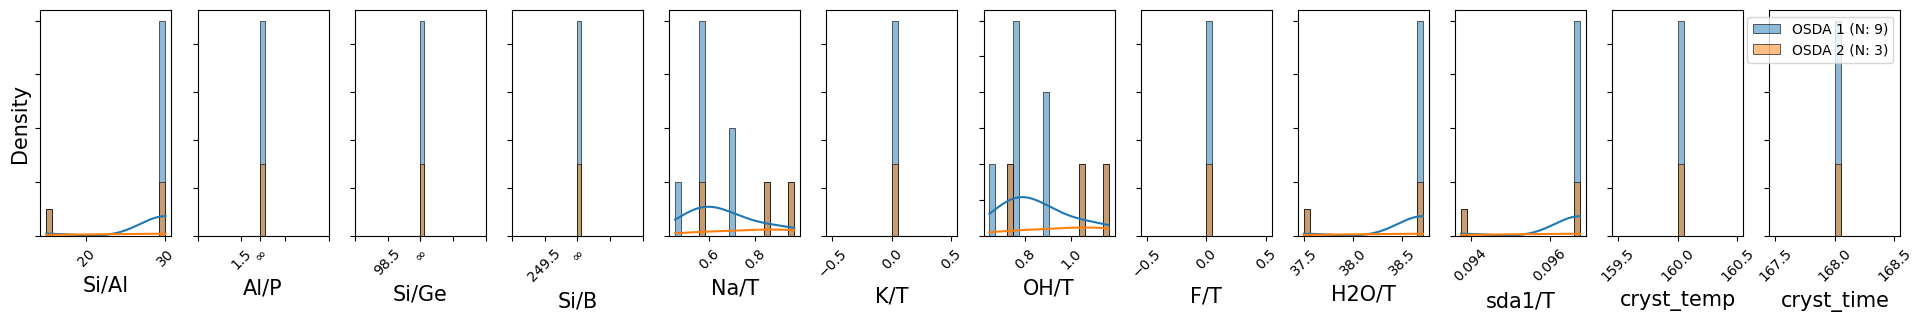

1
zeo: MOR
osda 1: CC[N+](CC)(CC)CCCCCCCCCC[N+](CC)(CC)CC 6
osda 2: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 3
osda similarity: 1.0
synthesis similarity: 0.99965763


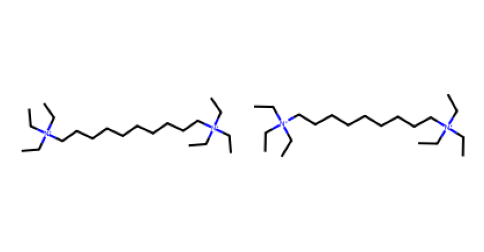

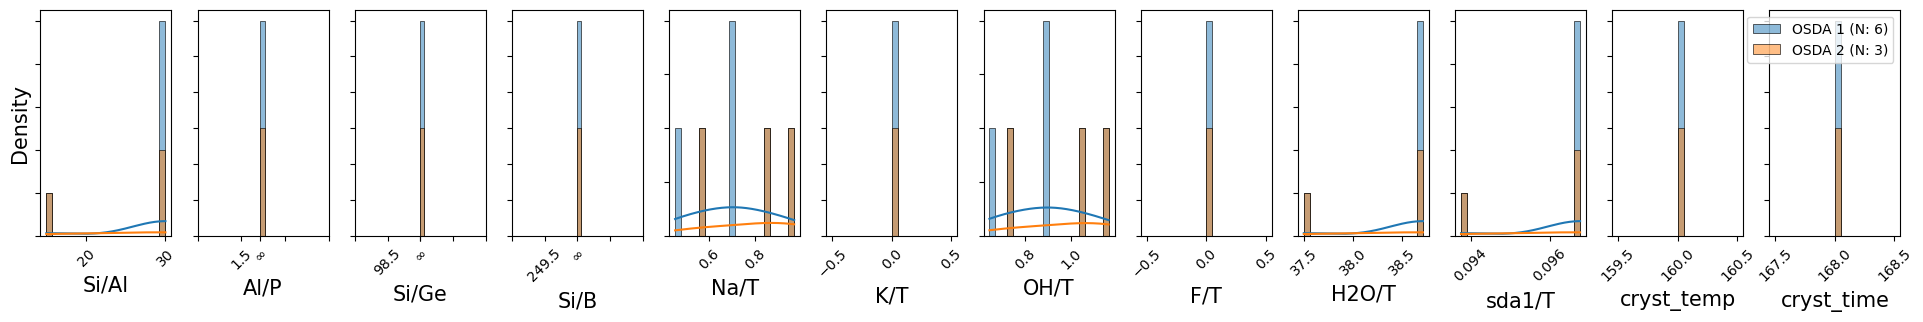

2
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9526736


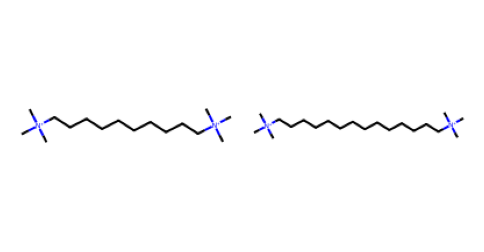

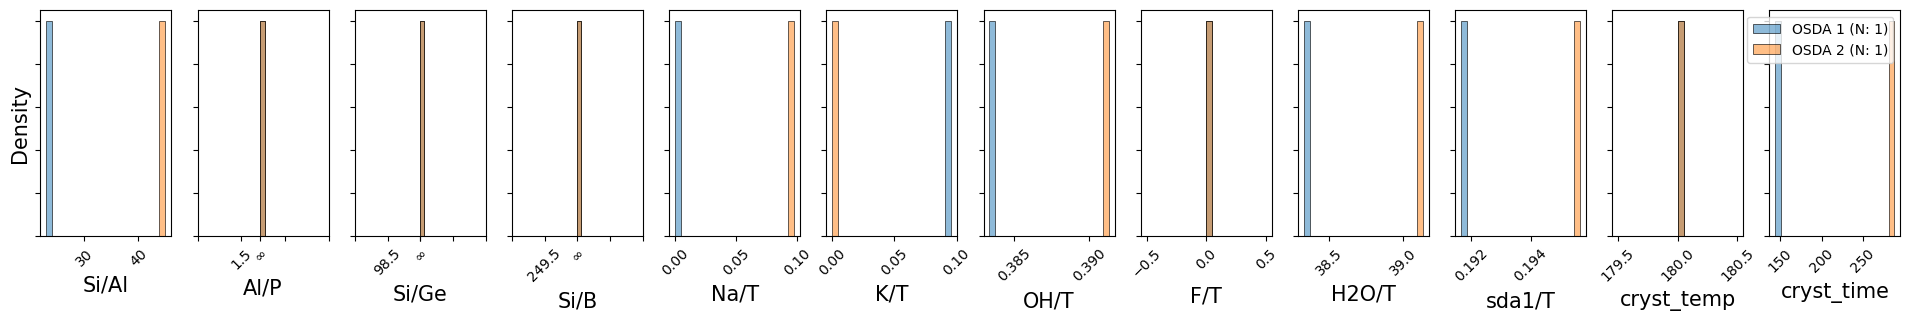

3
zeo: MEL
osda 1: NCCCCCCCCN 10
osda 2: NCCCCCCCCCCCCN 2
osda similarity: 1.0
synthesis similarity: 0.7198875


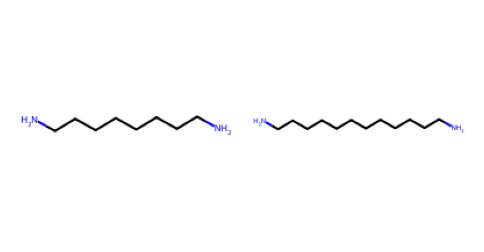

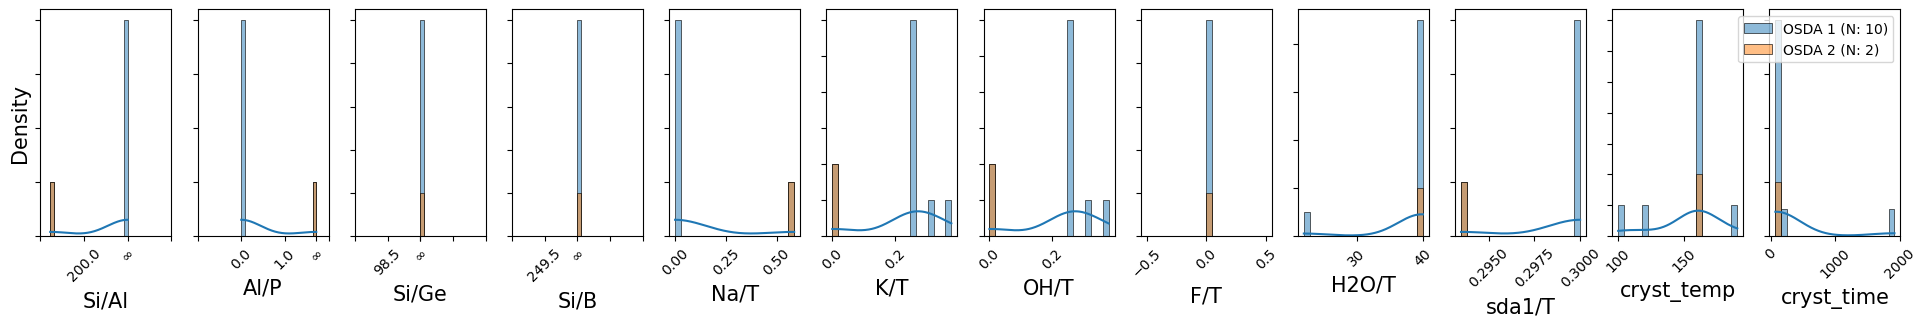

4
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9981285


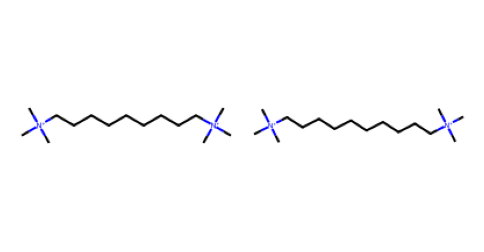

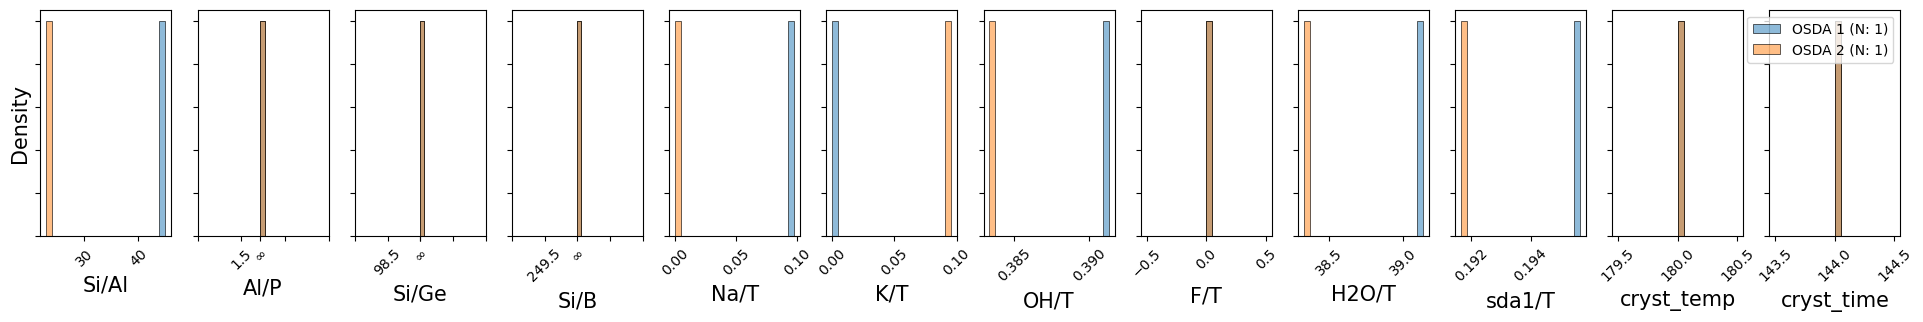

5
zeo: MFI
osda 1: CCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 6
osda 2: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 1
osda similarity: 1.0
synthesis similarity: 0.91512036


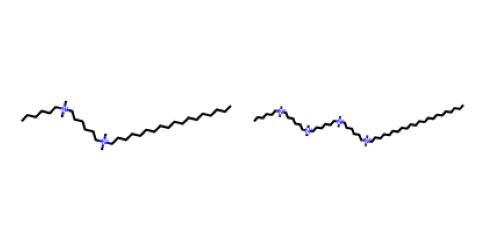

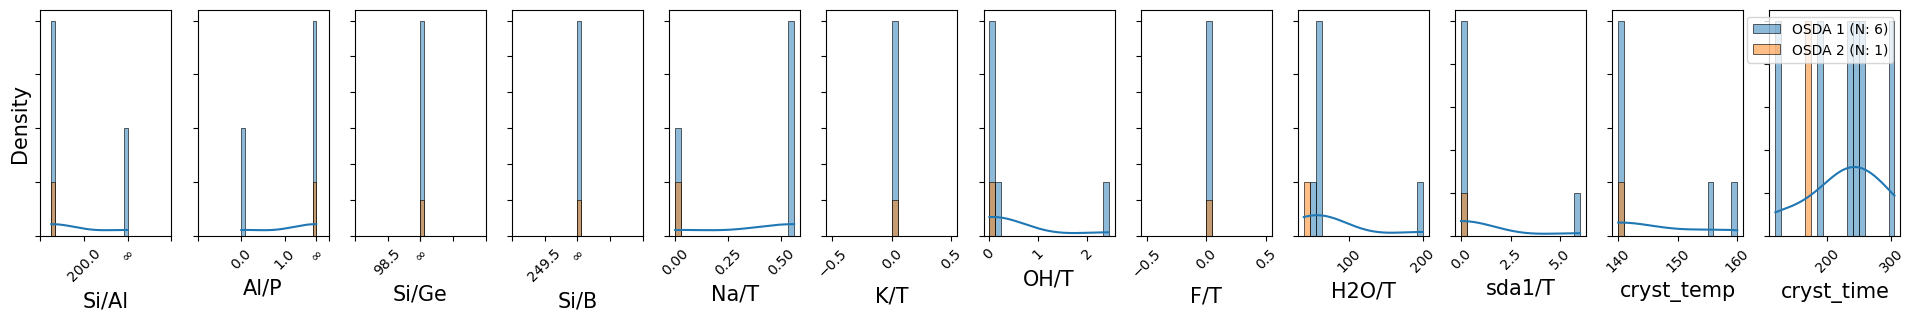

6
zeo: MRE
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.98165697


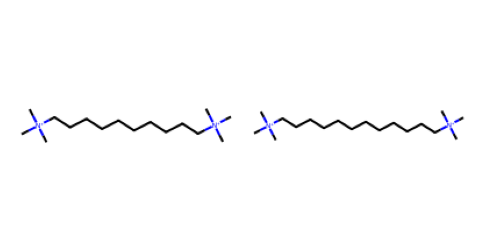

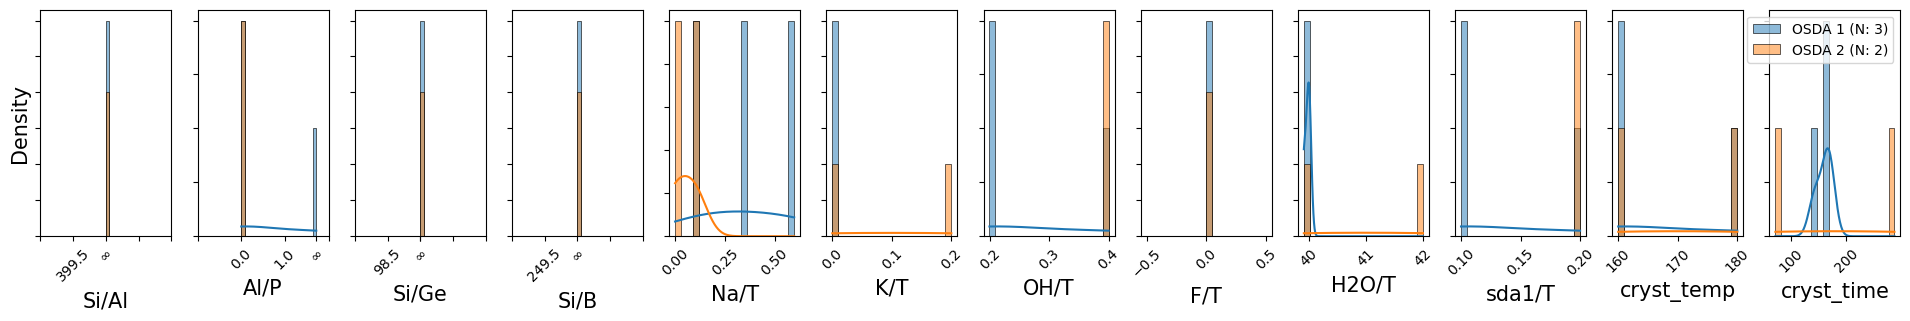

7
zeo: MRE
osda 1: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.9105169


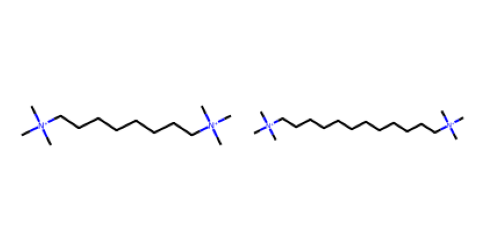

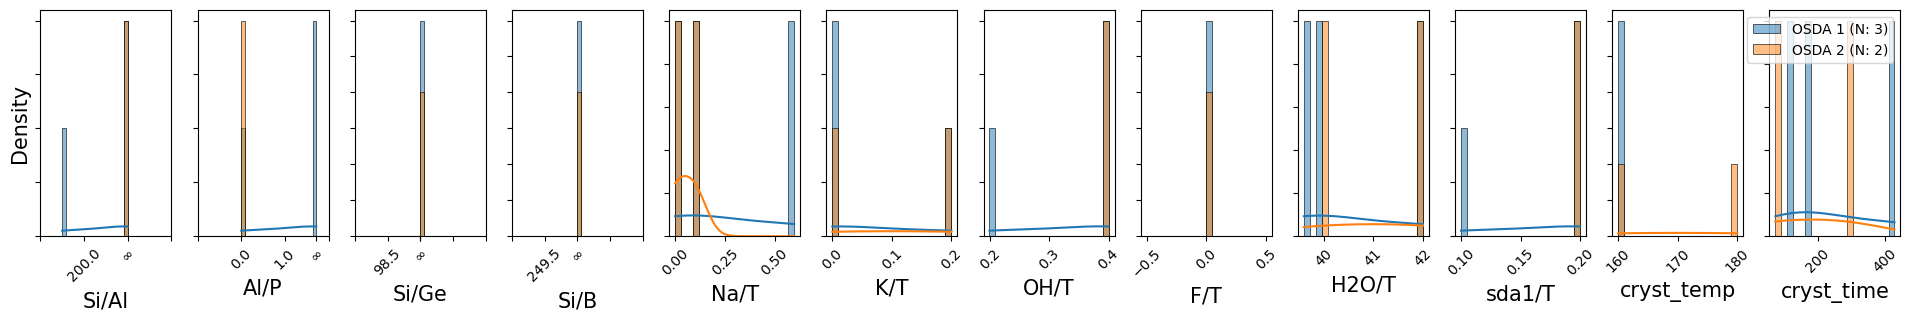

8
zeo: MTW
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.95340633


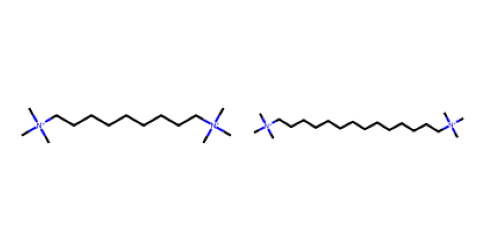

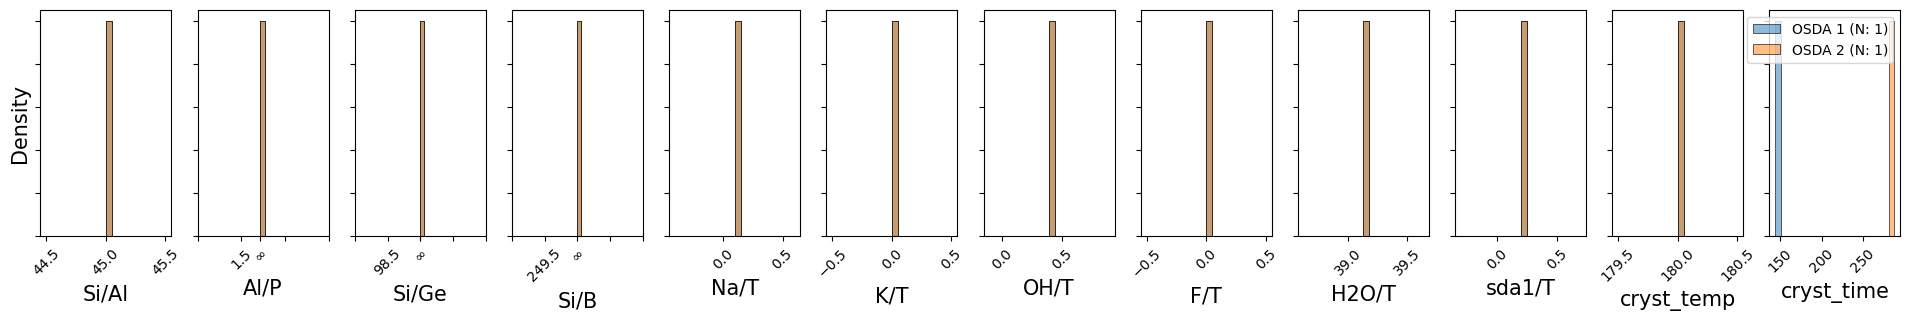

9
zeo: FER
osda 1: C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9764052


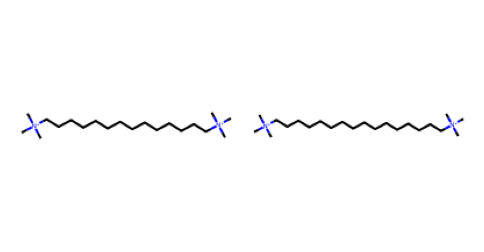

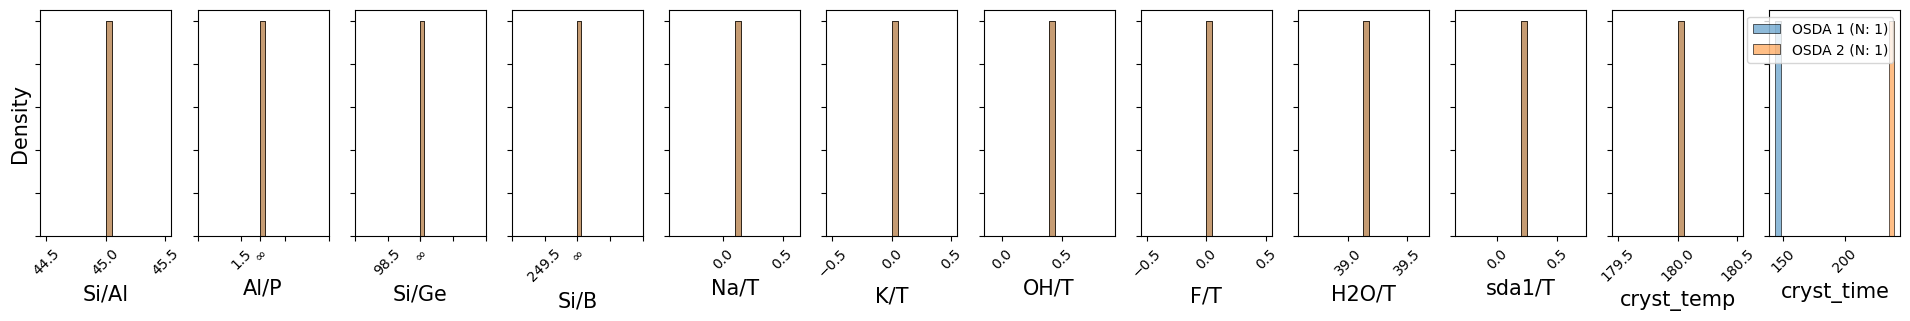

10
zeo: AFI
osda 1: CN[C@@H](C)[C@H](O)c1ccccc1 108
osda 2: CN[C@@H](C)[C@@H](O)c1ccccc1 51
osda similarity: 1.0
synthesis similarity: 0.94857347


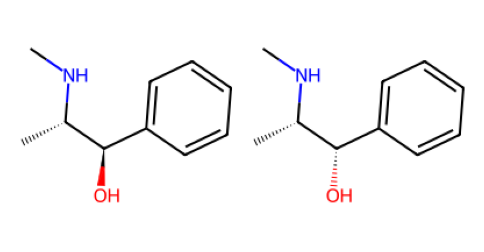

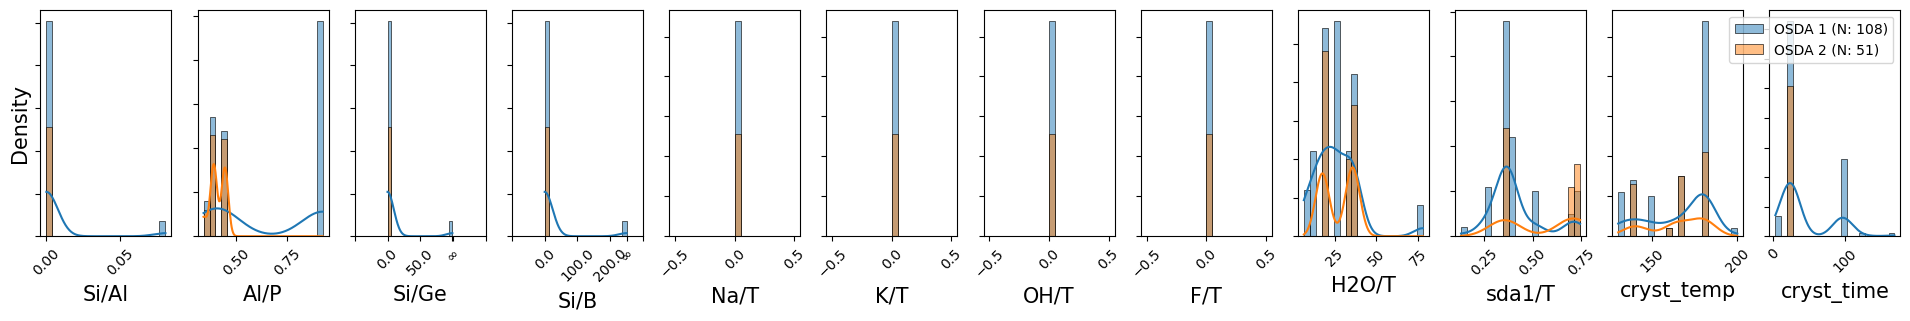

11
zeo: EMT
osda 1: C1COCCOCCOCCOCCOCCO1 47
osda 2: C1COCCOCCOCCOCCO1 20
osda similarity: 1.0
synthesis similarity: 0.91043794


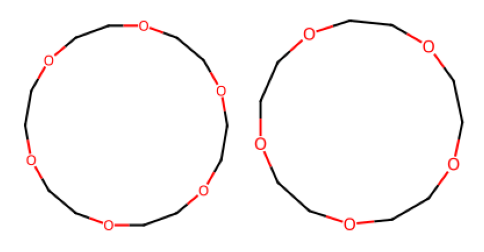

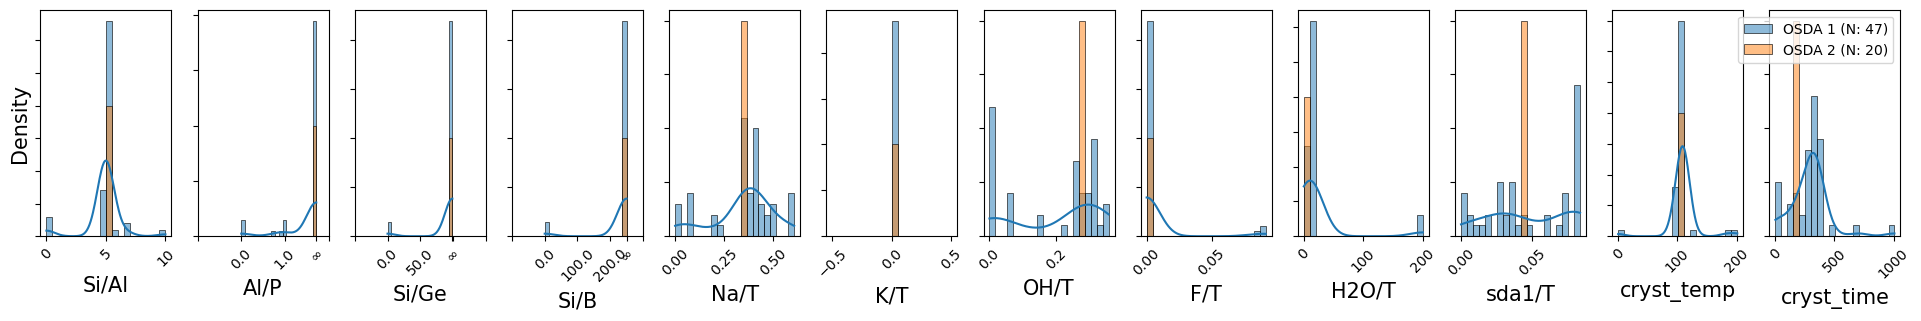

12
zeo: MFI
osda 1: CCC1CCCC[N+]1(C)C 2
osda 2: CC[C@@H]1CCCC[N+]1(C)C 1
osda similarity: 1.0
synthesis similarity: 0.7361247


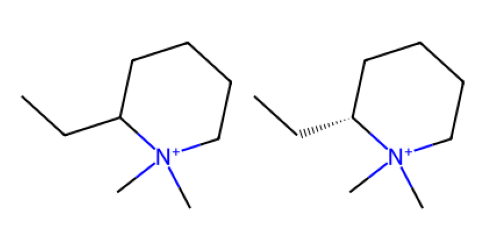

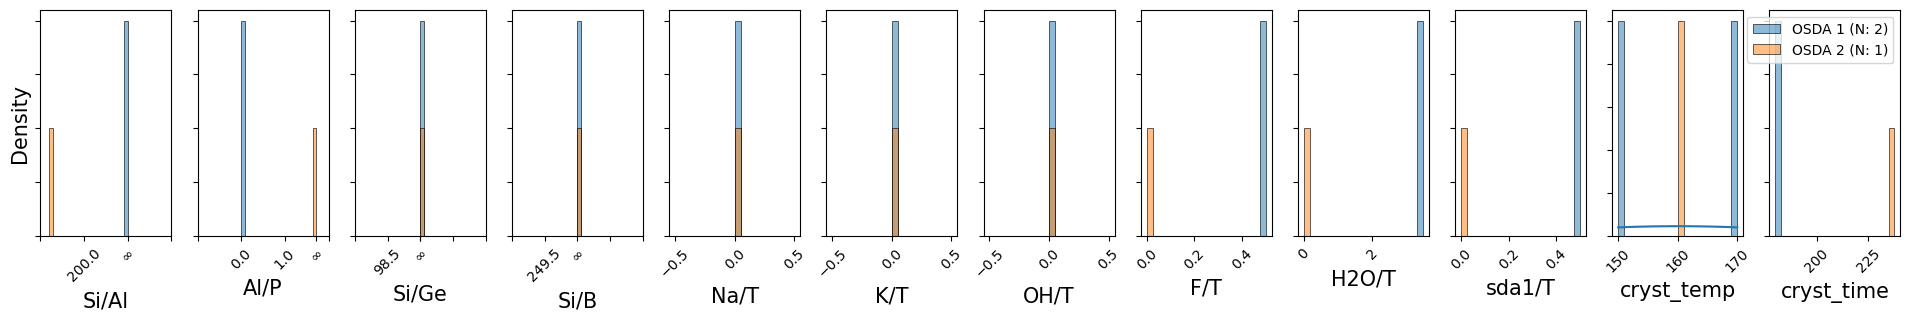

13
zeo: MFI
osda 1: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 25
osda 2: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC[N+](C)(C)CCCCCC 1
osda similarity: 1.0
synthesis similarity: 0.9231764


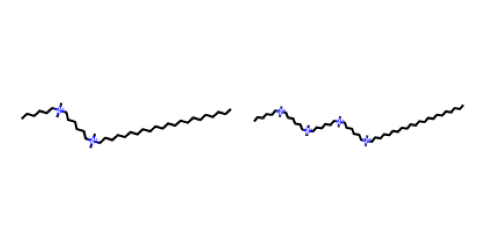

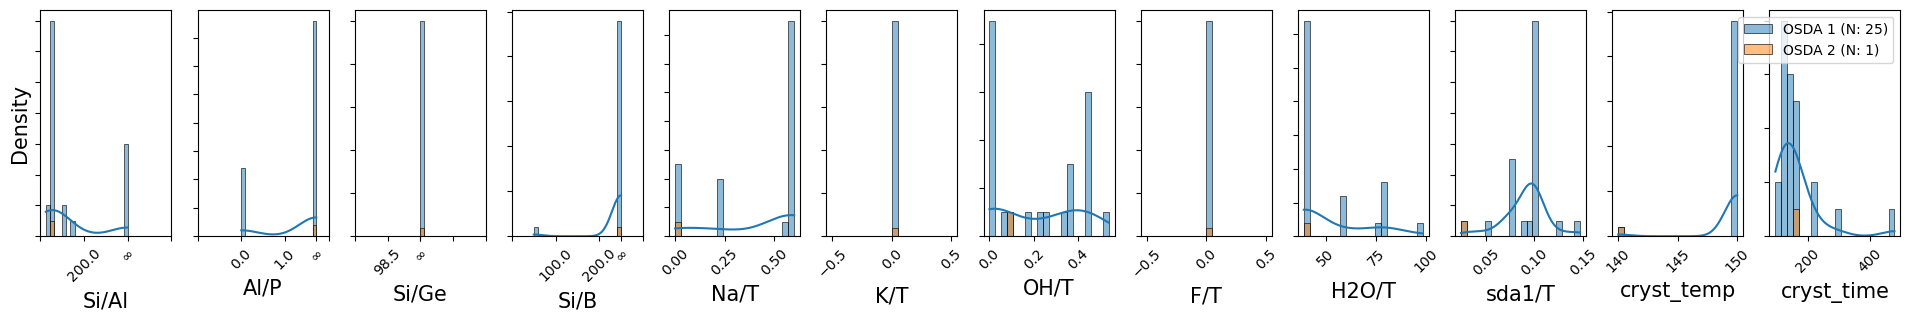

14
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCC[N+](C)(C)C 14
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.79091895


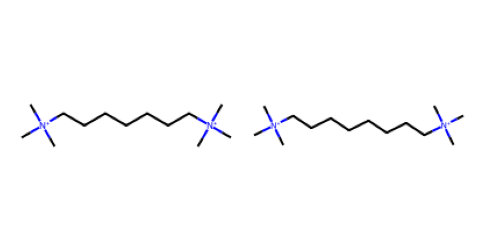

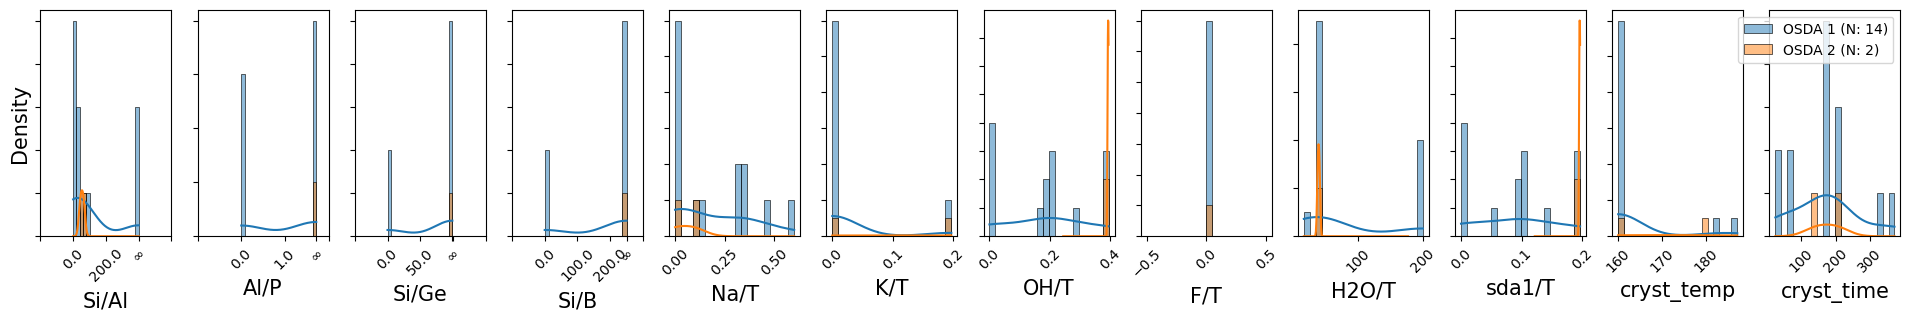

15
zeo: TON
osda 1: C[n+]1ccn(CCCCCCCCn2cc[n+](C)c2)c1 3
osda 2: C[n+]1ccn(CCCCCCCCCCn2cc[n+](C)c2)c1 1
osda similarity: 1.0
synthesis similarity: 0.9814744


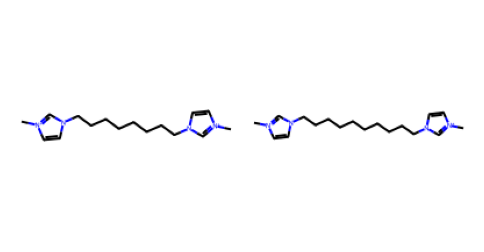

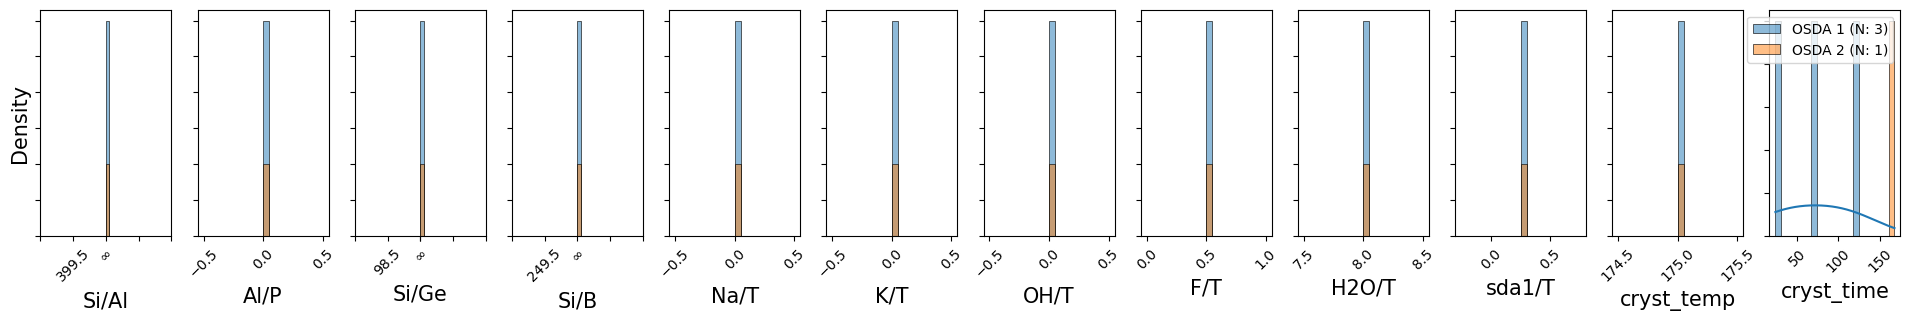

16
zeo: FER
osda 1: C[N@@+]1(Cc2ccccc2)CCC[C@H]1CO 2
osda 2: C[N@@+]1(Cc2ccccc2)CCCC1CO 1
osda similarity: 1.0
synthesis similarity: 0.9759445


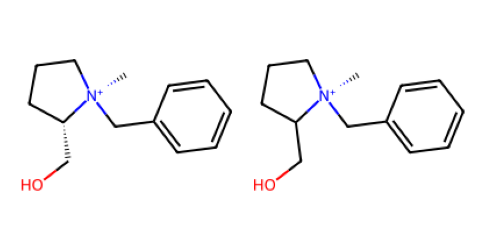

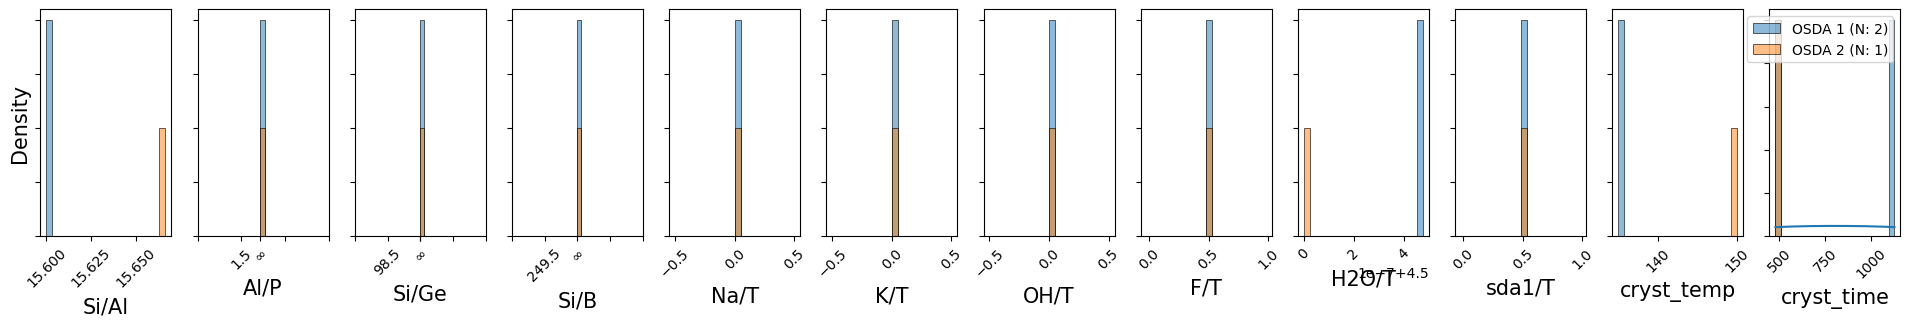

17
zeo: ANA
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 2
osda 2: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 1.0


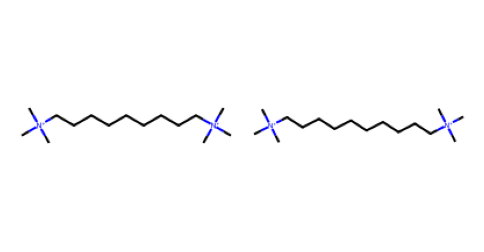

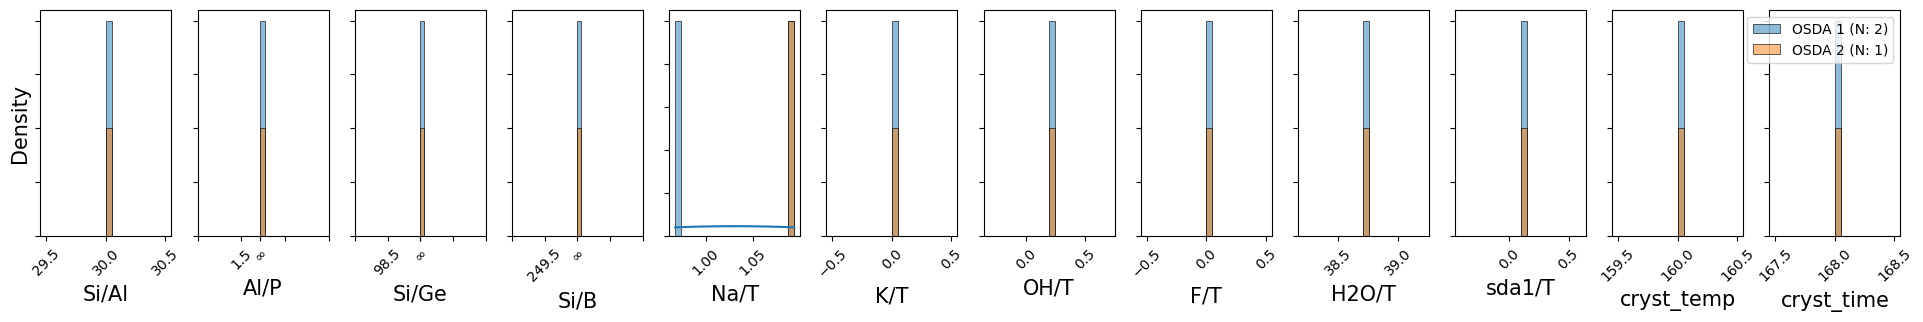

18
zeo: AFI
osda 1: C[C@@H]([C@H](O)c1ccccc1)N(C)Cc1ccccc1 4
osda 2: C[C@@H]([C@@H](O)c1ccccc1)N(C)Cc1ccccc1 4
osda similarity: 1.0
synthesis similarity: 0.99955434


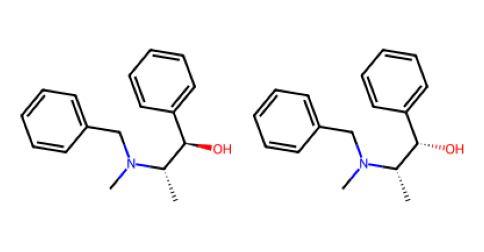

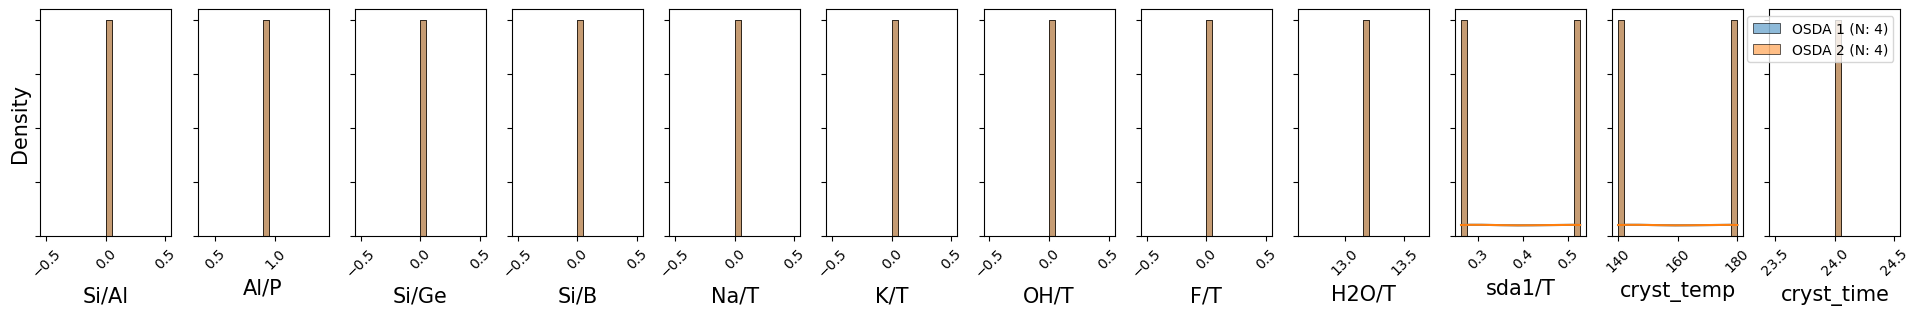

19
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCCCCCCC[N+](C)(C)C 2
osda 2: C[N+](C)(C)CCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9929917


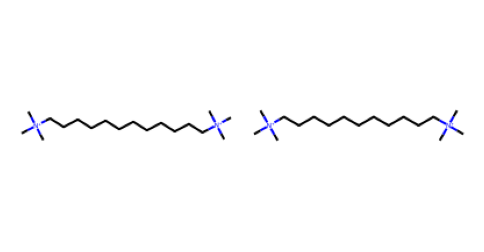

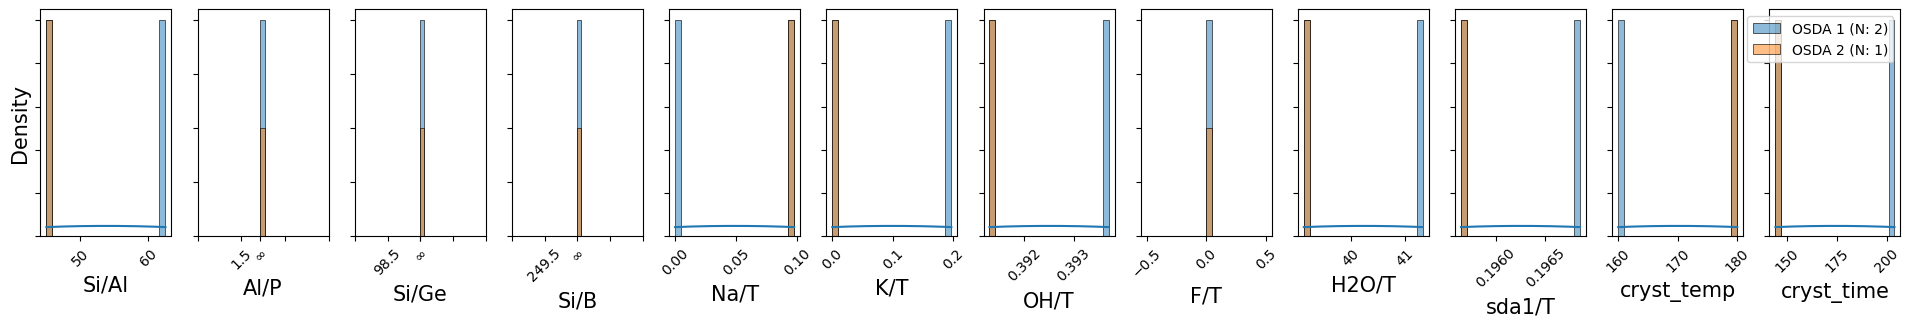

20
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 2
osda 2: C[N+](C)(C)CCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.9929917


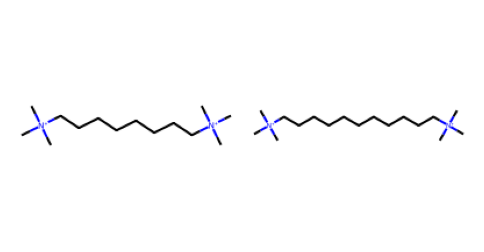

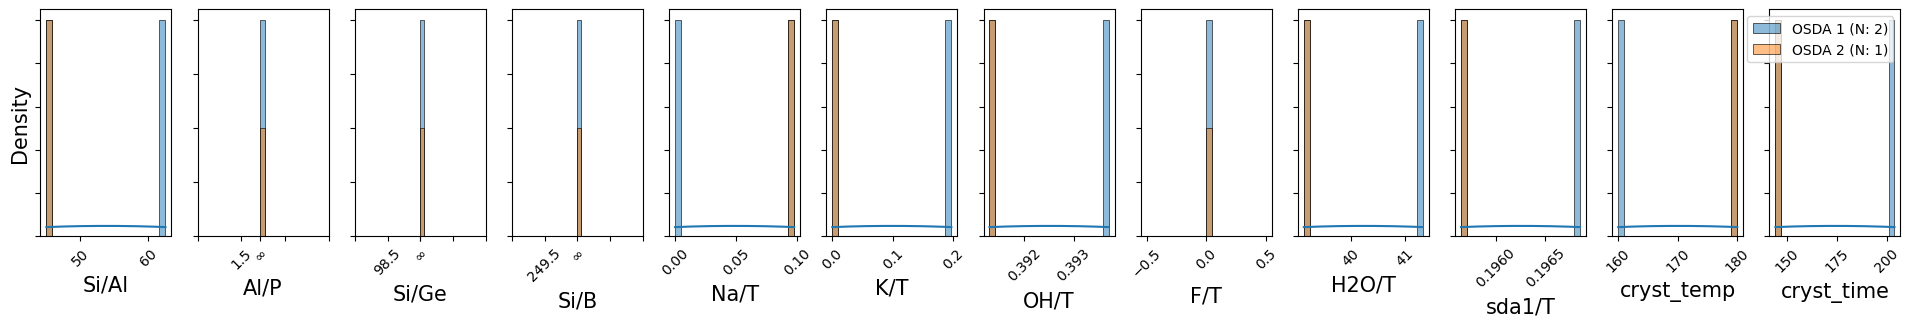

21
zeo: MFI
osda 1: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 5
osda 2: CC[N+](CC)(CC)CCCCCCC[N+](CC)(CC)CC 4
osda similarity: 1.0
synthesis similarity: 0.99999845


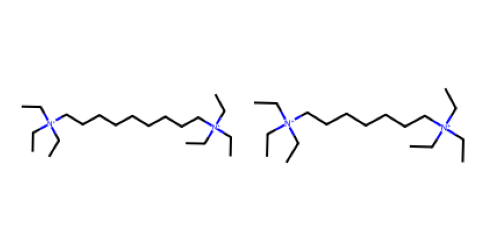

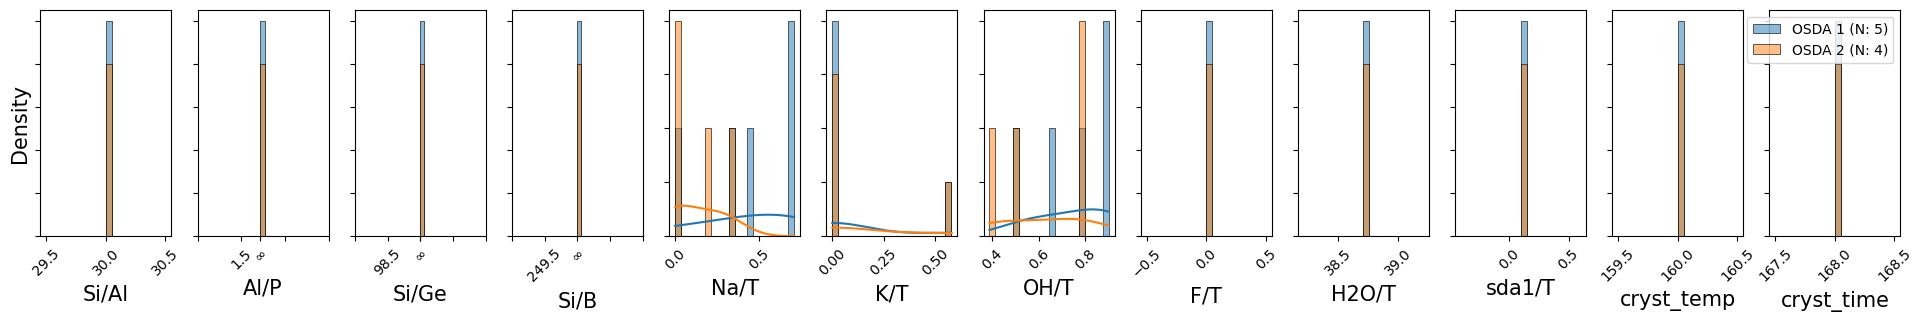

22
zeo: SAS
osda 1: CC[N@@+]1(C)C[C@@H]2CC[C@](C)(C1)C2(C)C 1
osda 2: CC[N+]1(C)CC2CCC(C)(C1)C2(C)C 1
osda similarity: 1.0
synthesis similarity: 0.919


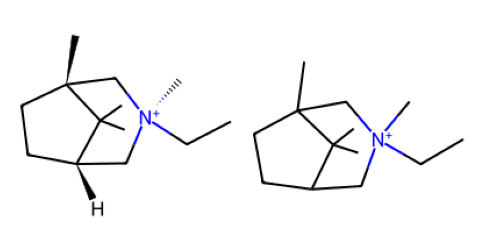

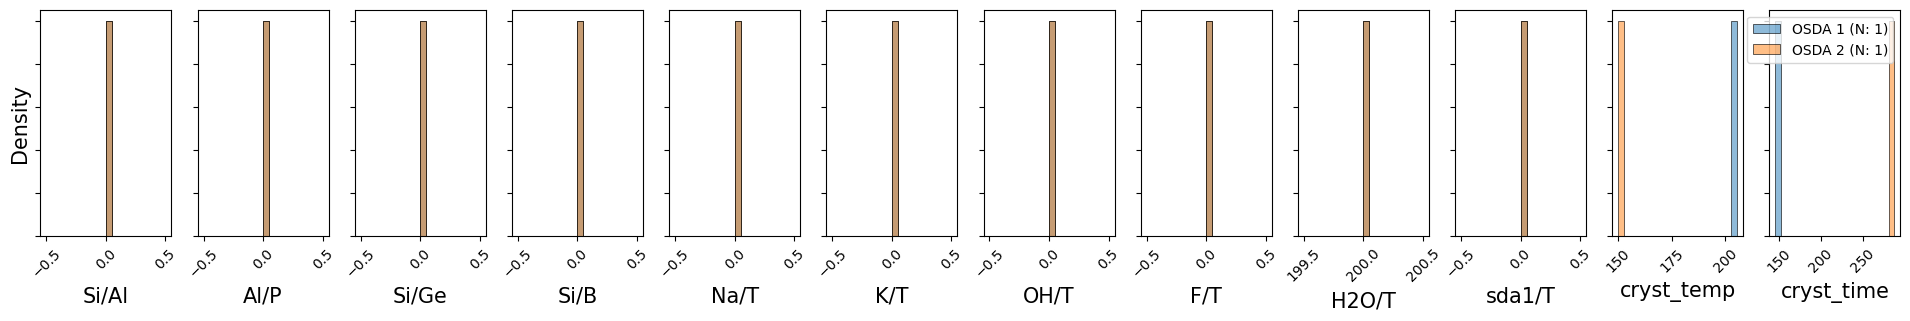

23
zeo: MFI
osda 1: CCCCCCCC[N+](C)(C)C 2
osda 2: CCCCCCCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.34171233


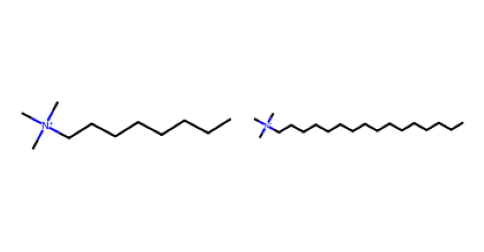

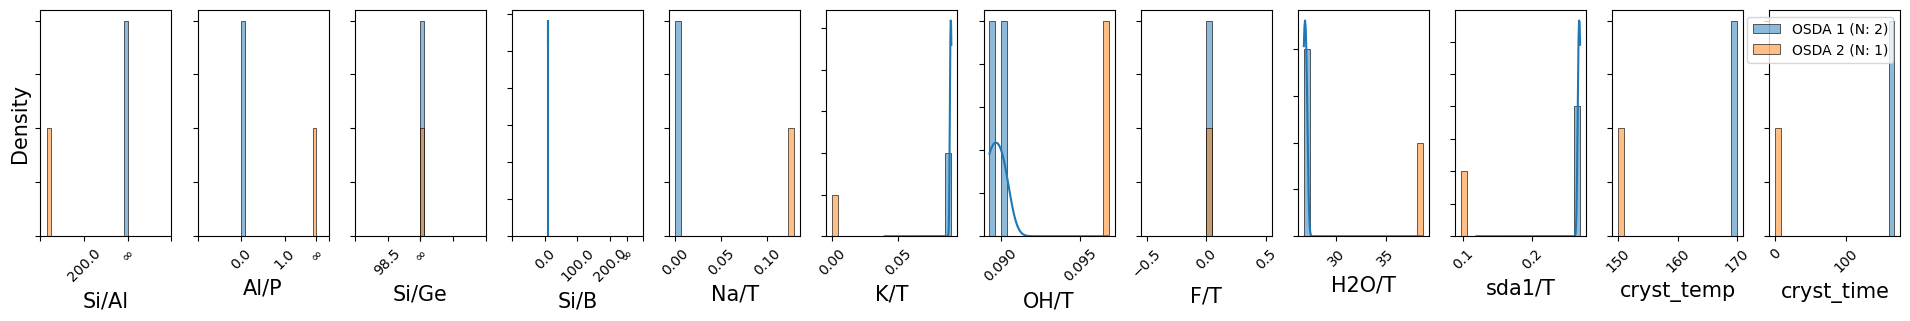

24
zeo: MFI
osda 1: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 4
osda 2: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.86316055


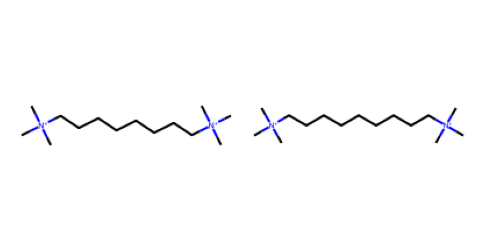

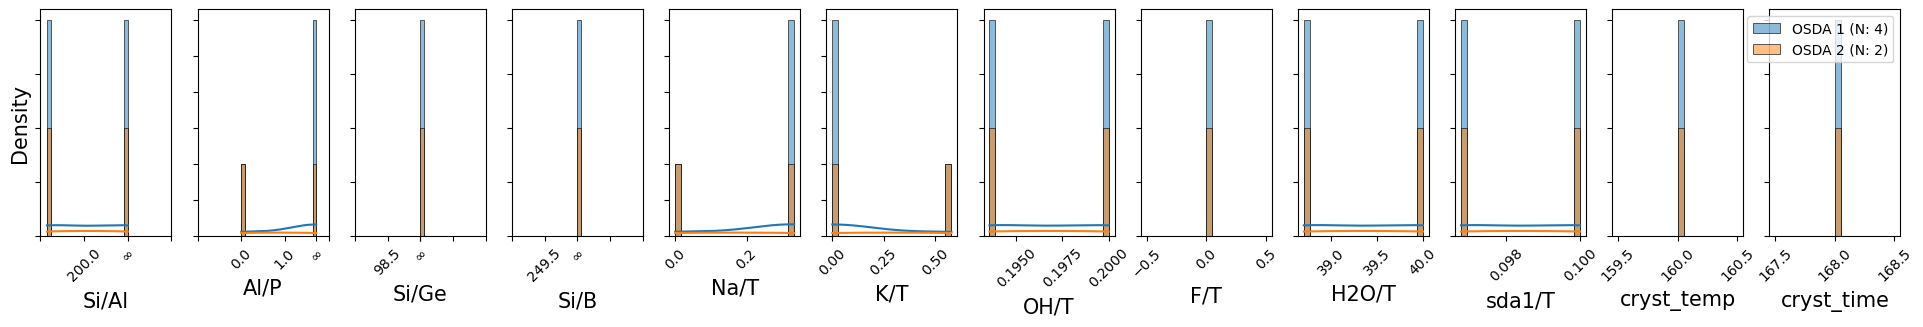

25
zeo: MFI
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.8557172


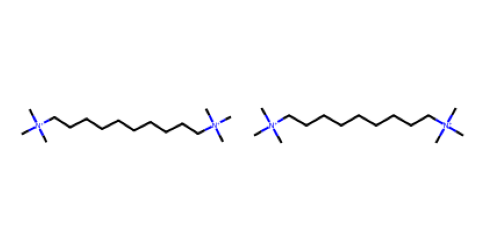

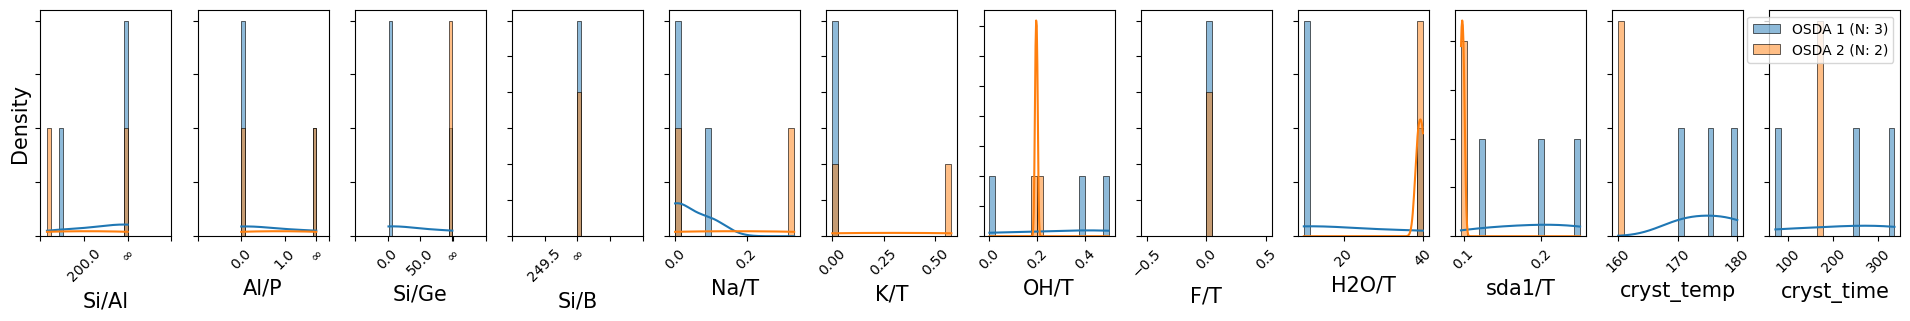

26
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCC[N+](C)(C)C 14
osda 2: C[N+](C)(C)CCCCCCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.79091895


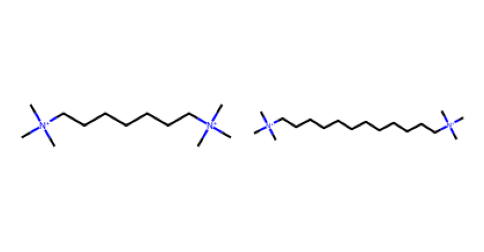

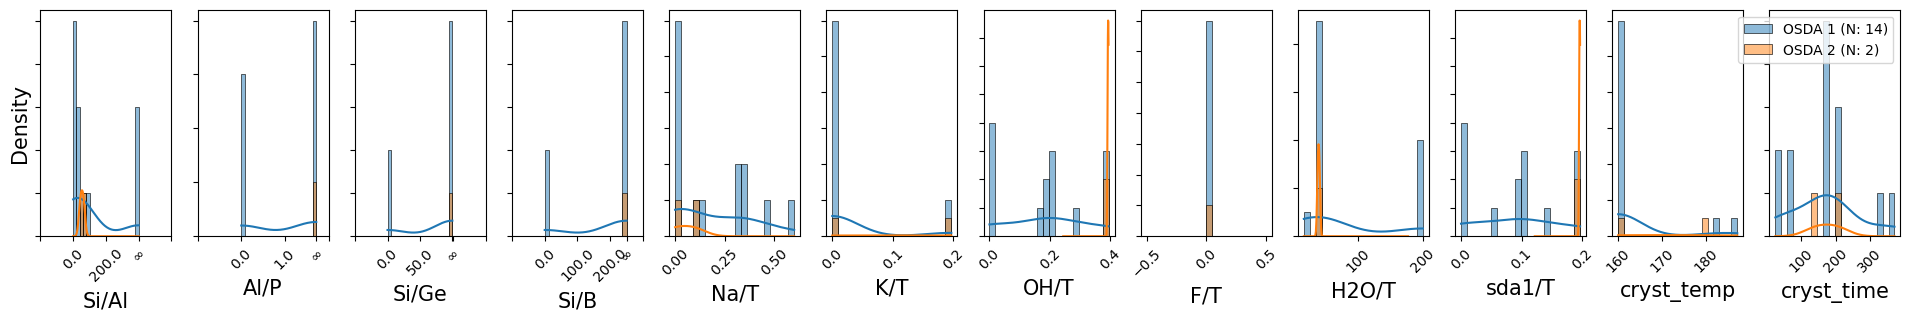

27
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCCCCCCC[N+](C)(C)C 2
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 2
osda similarity: 1.0
synthesis similarity: 0.9929918


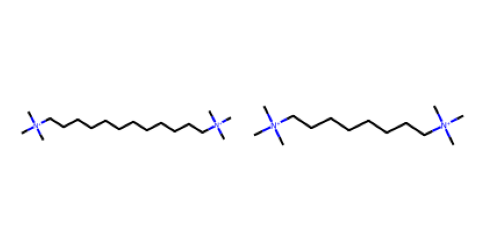

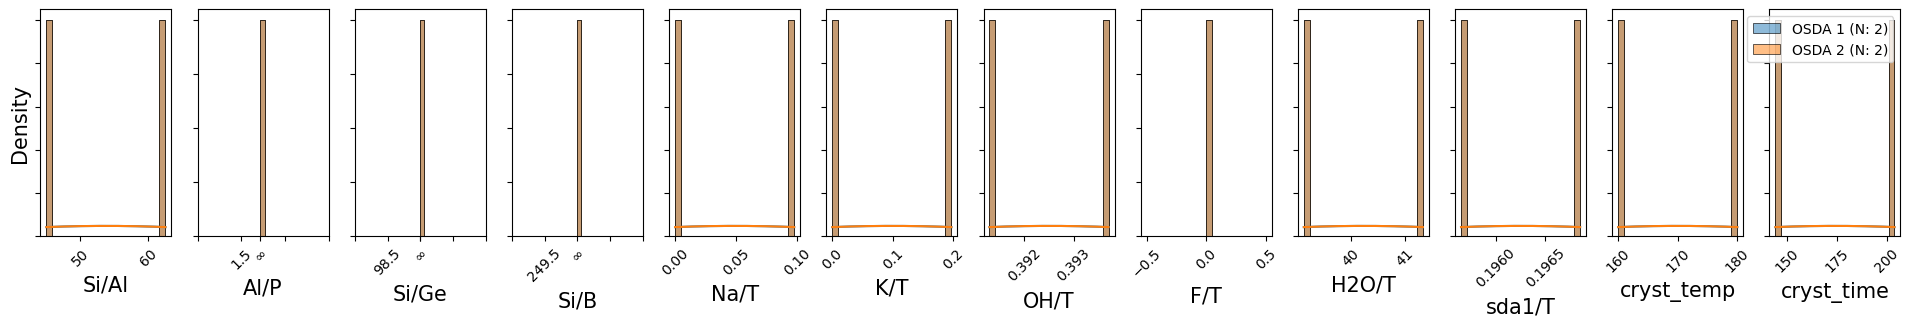

28
zeo: STO
osda 1: C[N+](C)(C)[C@@H]1C[C@H]2C[C@@H]1C1CCCC12 1
osda 2: C[N+](C)(C)C1CC2CC1C1CCCC21 1
osda similarity: 1.0
synthesis similarity: 0.98899174


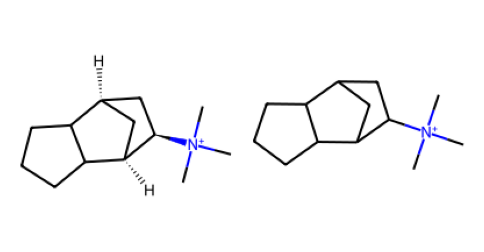

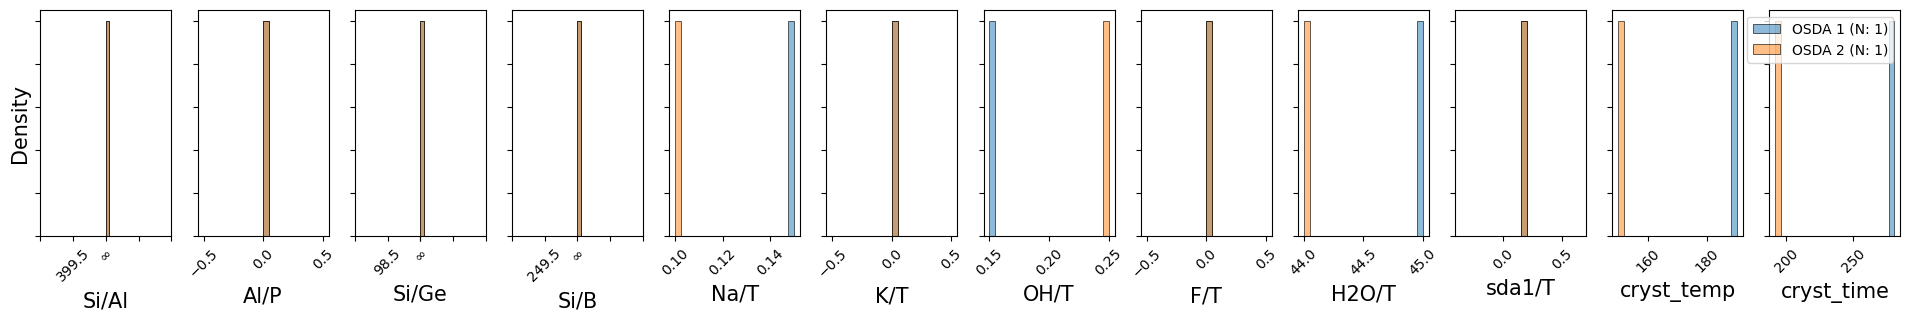

29
zeo: MOR
osda 1: CC[N+](CC)(CC)CCCCCCCCCC[N+](CC)(CC)CC 6
osda 2: CC[N+](CC)(CC)CCCCCCCC[N+](CC)(CC)CC 3
osda similarity: 1.0
synthesis similarity: 0.99965763


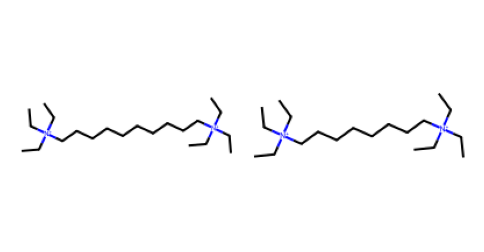

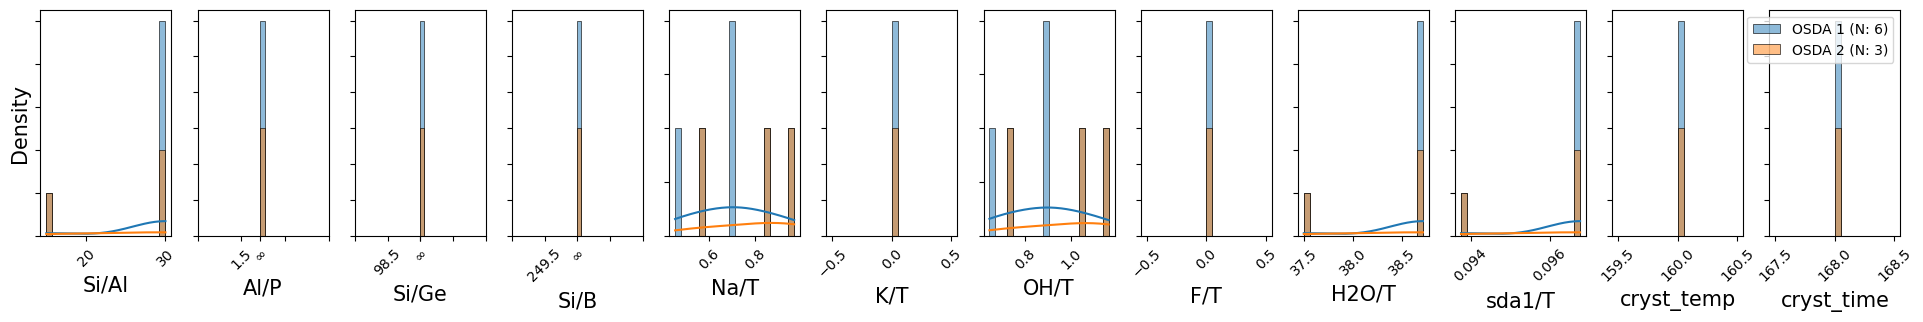

30
zeo: MOR
osda 1: C[N+](C)(C)CCCCCCCCC[N+](C)(C)C 6
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 3
osda similarity: 1.0
synthesis similarity: 0.9087753


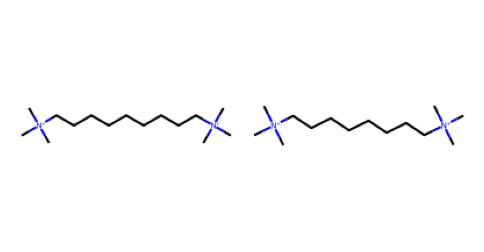

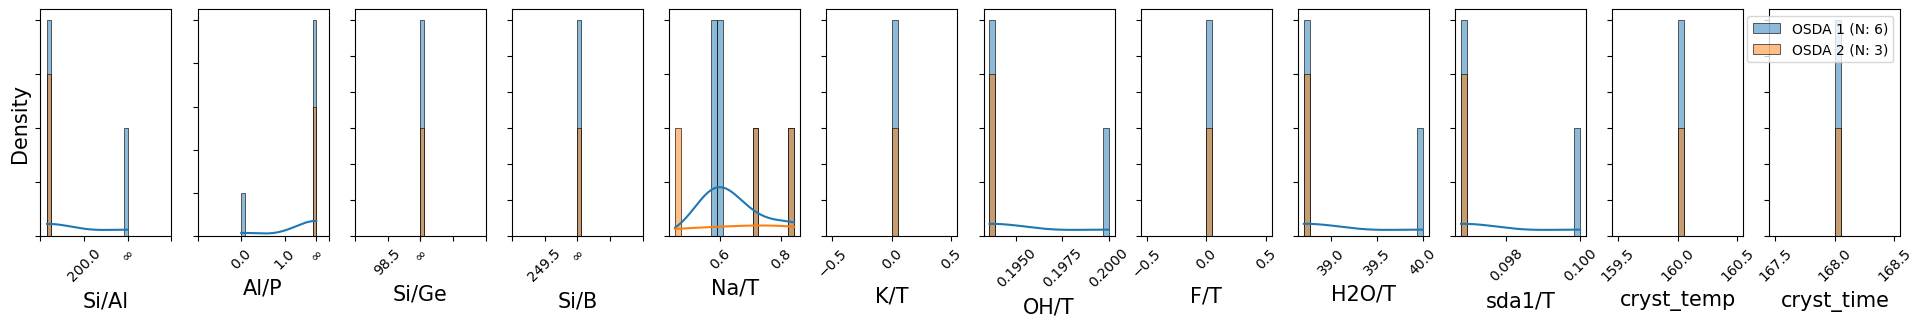

31
zeo: MTT
osda 1: C[N+](C)(C)CCCCCCC[N+](C)(C)C 14
osda 2: C[N+](C)(C)CCCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 0.78699857


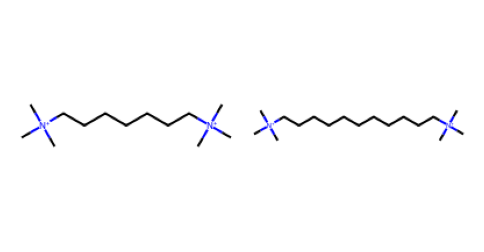

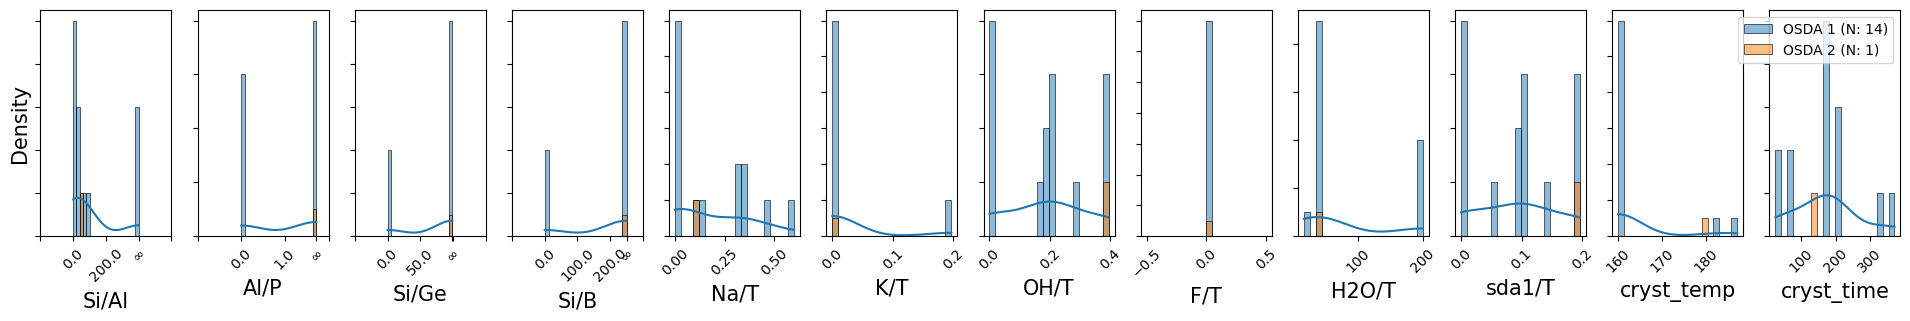

32
zeo: MEL
osda 1: NCCCCCCCCCCCCN 2
osda 2: NCCCCCCCN 2
osda similarity: 1.0
synthesis similarity: 0.6046611


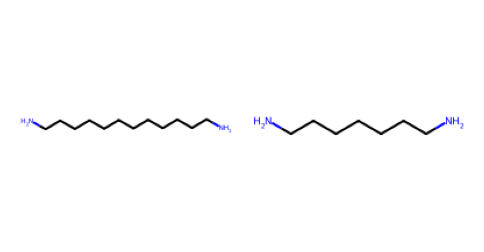

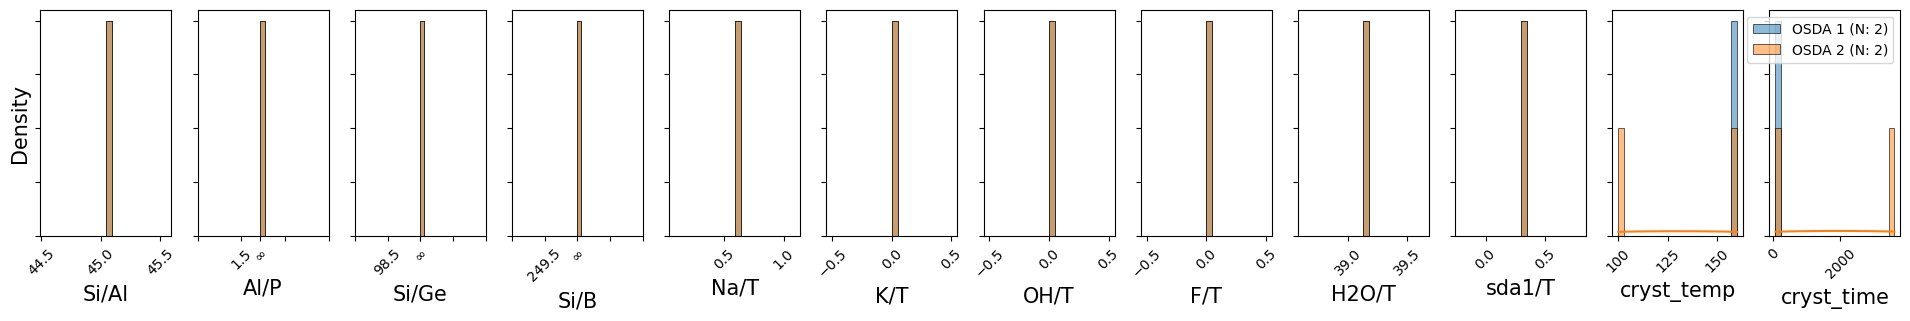

33
zeo: MEL
osda 1: NCCCCCCCCN 10
osda 2: NCCCCCCCN 2
osda similarity: 1.0
synthesis similarity: 0.50541127


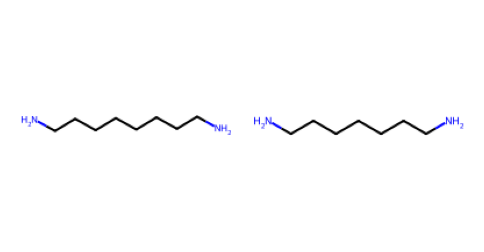

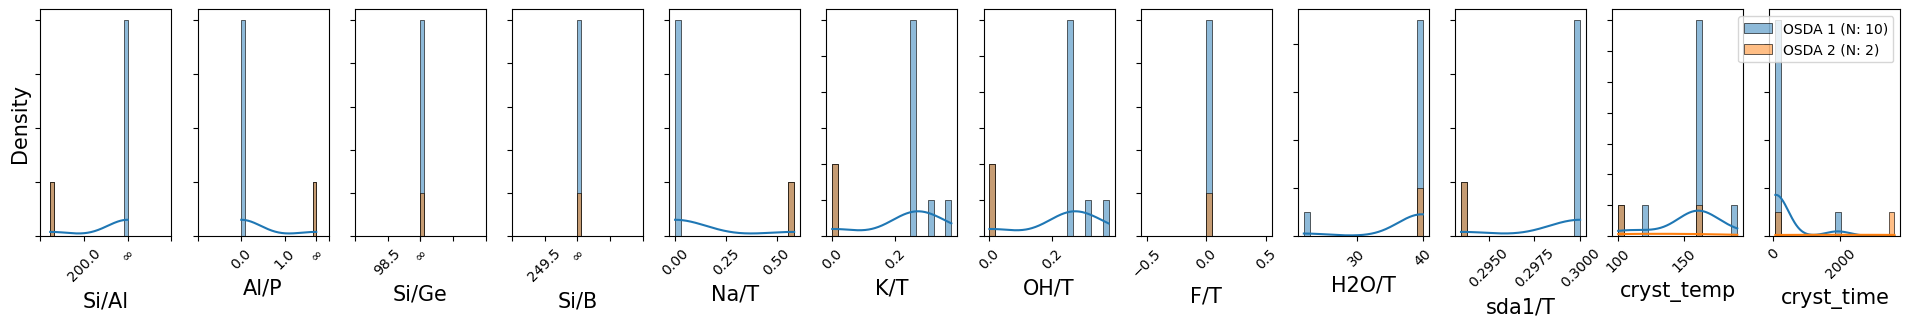

34
zeo: MOR
osda 1: CC1CCCC(C)[N+]1(C)C 4
osda 2: C[C@H]1CCC[C@@H](C)[N+]1(C)C 1
osda similarity: 1.0
synthesis similarity: 0.96943814


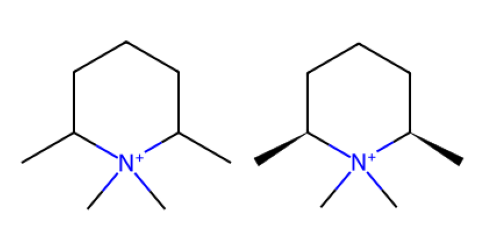

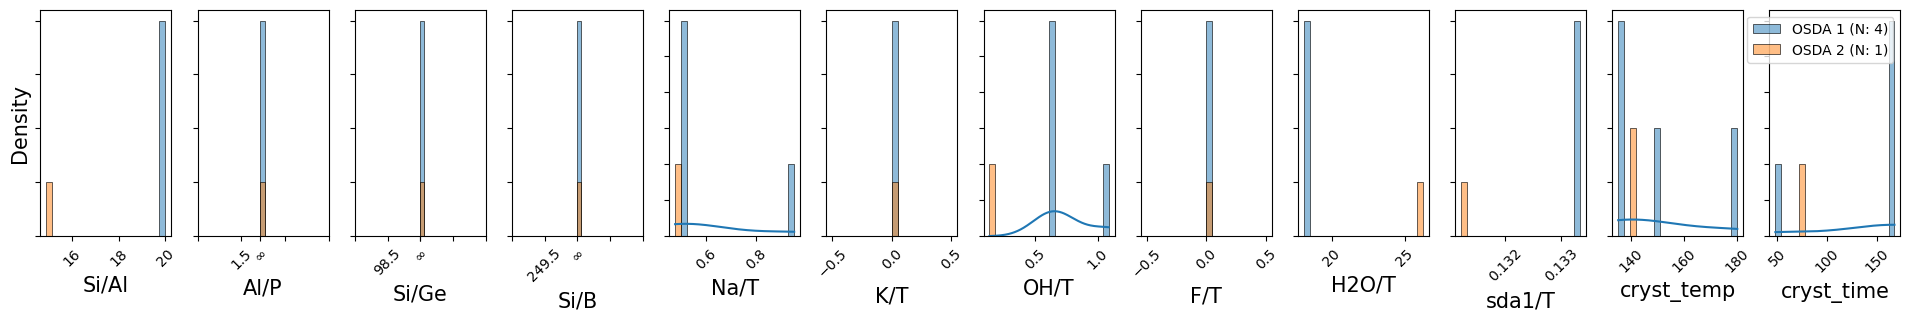

35
zeo: MOR
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 7
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 3
osda similarity: 1.0
synthesis similarity: 0.92180735


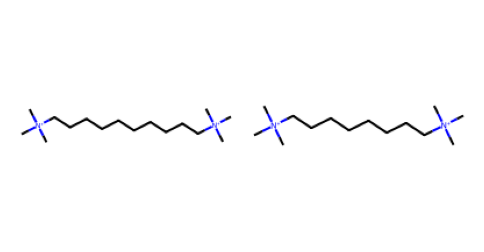

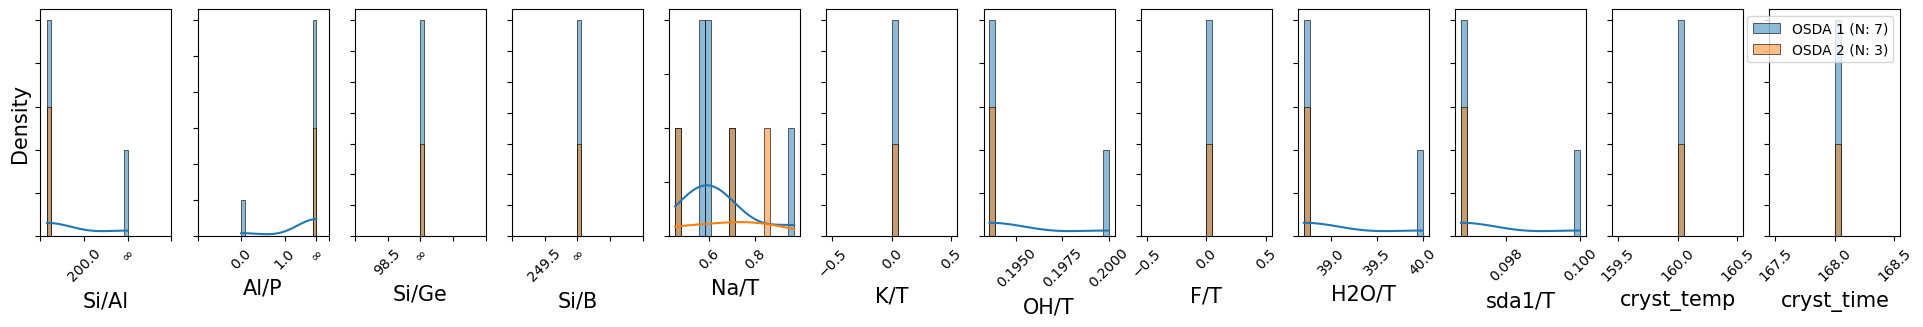

36
zeo: MOR
osda 1: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 3
osda 2: CC[N+](CC)(CC)CCCCCCCC[N+](CC)(CC)CC 3
osda similarity: 1.0
synthesis similarity: 0.99960876


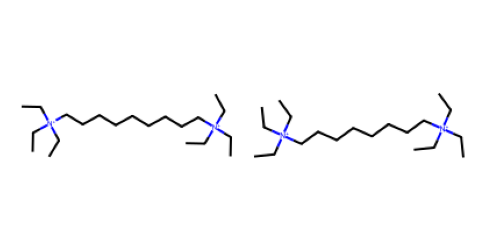

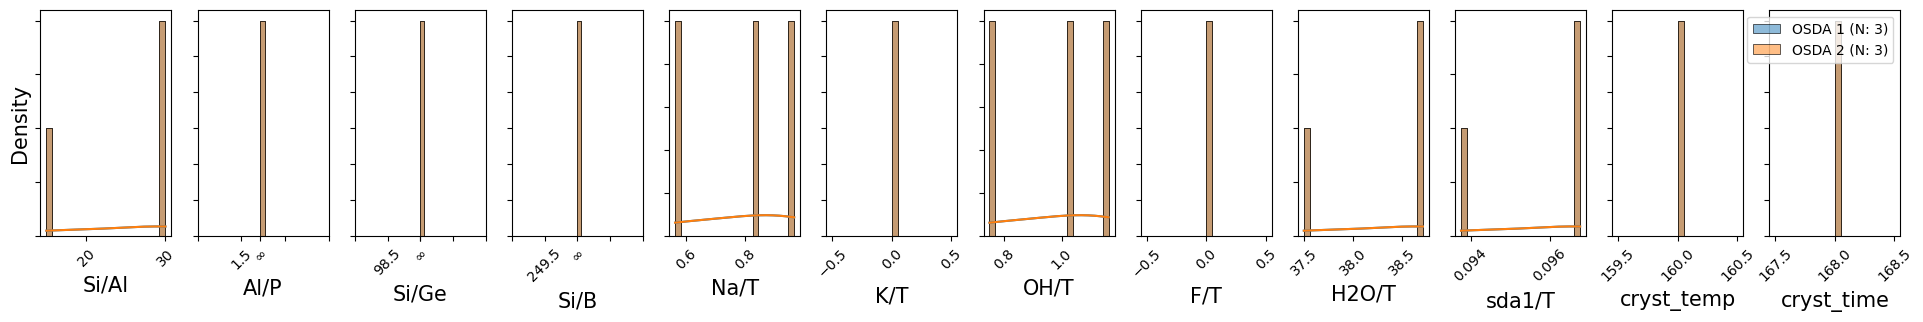

37
zeo: MRE
osda 1: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 3
osda 2: C[N+](C)(C)CCCCCCCC[N+](C)(C)C 3
osda similarity: 1.0
synthesis similarity: 0.9225557


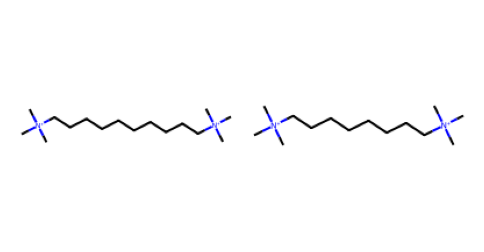

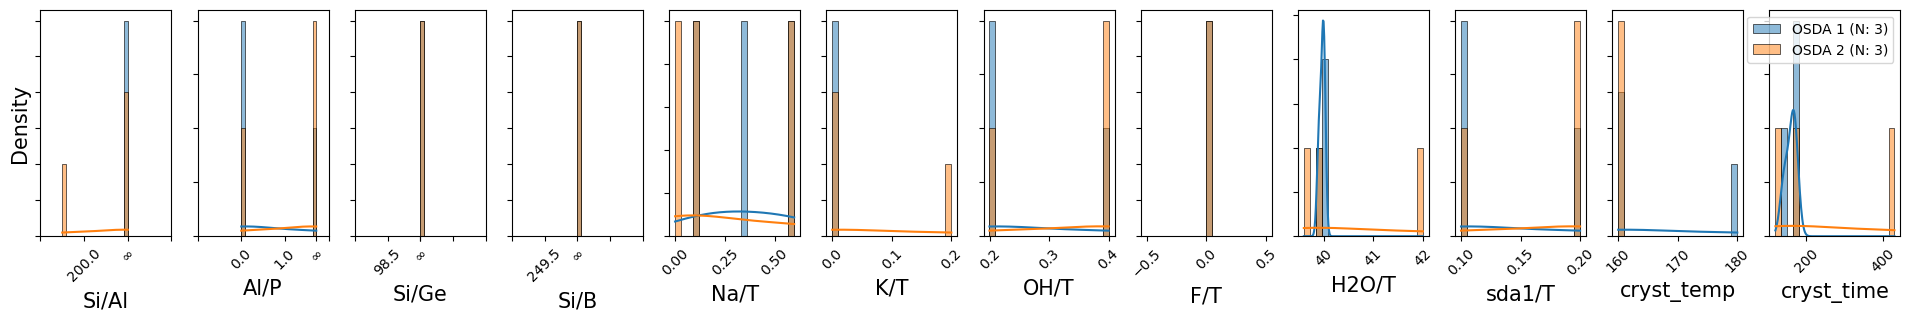

38
zeo: STF
osda 1: C[C@H]1CCC[C@@H](C)[N+]12CCCC2 12
osda 2: CC1CCCC(C)[N+]12CCCC2 8
osda similarity: 1.0
synthesis similarity: 0.722069


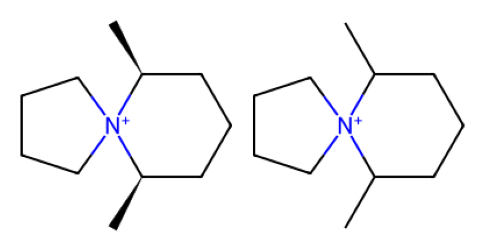

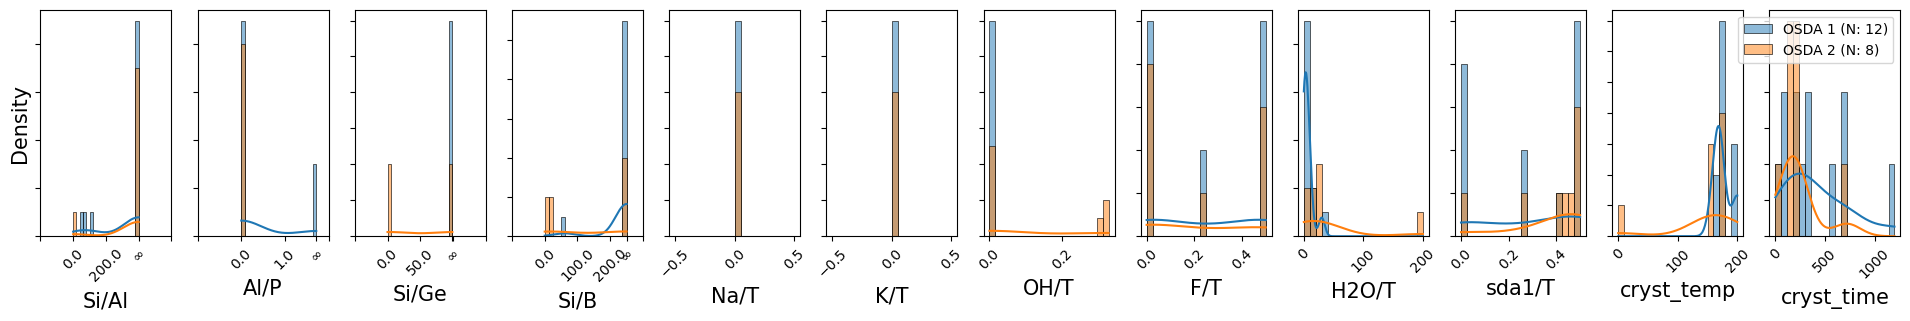

39
zeo: MFI
osda 1: CC[N+](CC)(CC)CCCCCCCC[N+](CC)(CC)CC 11
osda 2: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 5
osda similarity: 1.0
synthesis similarity: 0.99968886


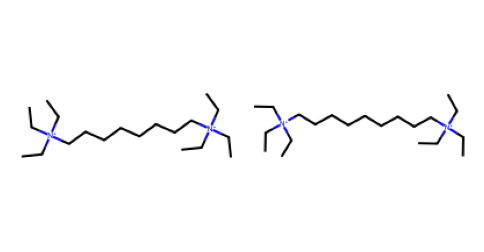

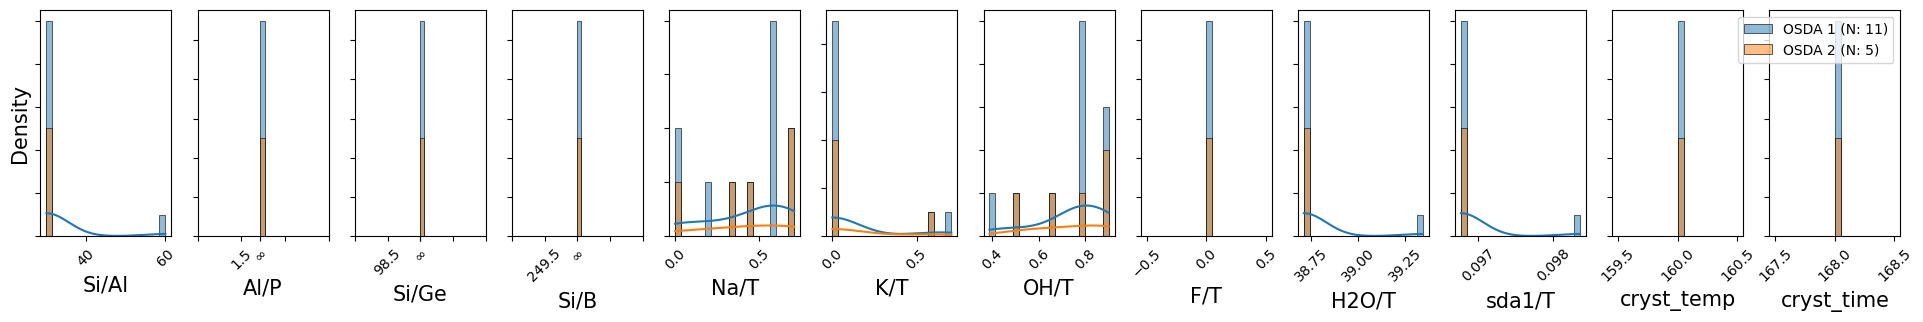

40
zeo: LTA
osda 1: C1COCCOCCOCCN1 1
osda 2: C1COCCOCCOCCOCCOCCN1 1
osda similarity: 1.0
synthesis similarity: 1.0


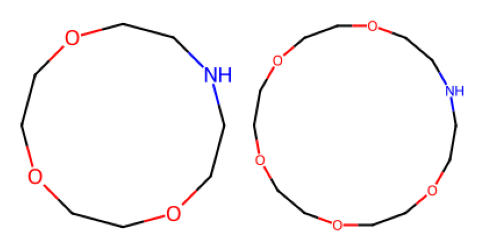

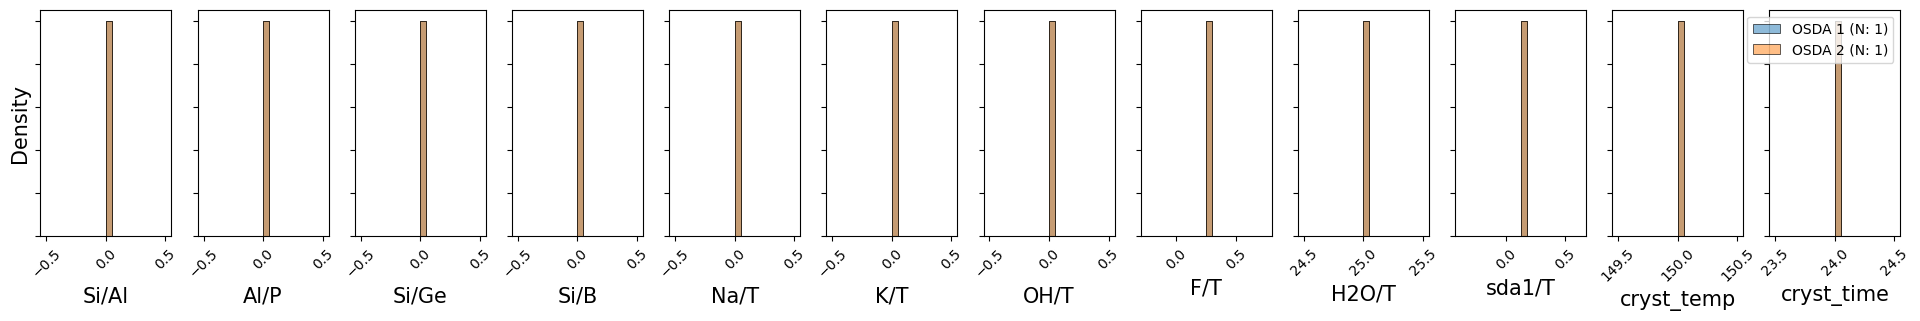

41
zeo: LTA
osda 1: C1COCCOCCOCCOCCOCCN1 1
osda 2: C1COCCOCCOCCOCCN1 1
osda similarity: 1.0
synthesis similarity: 1.0


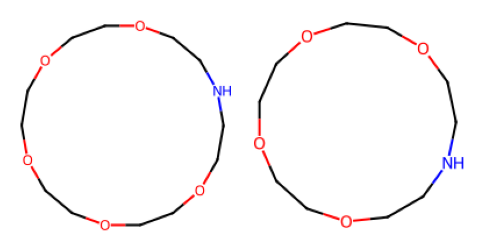

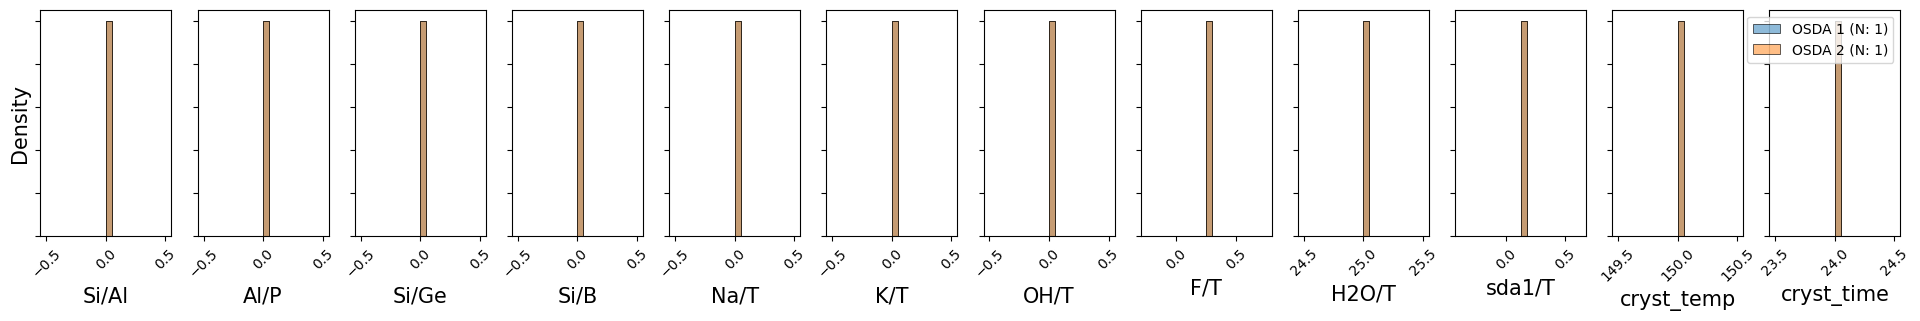

42
zeo: MFI
osda 1: CC[N+](CC)(CC)CCCCCCCCCC[N+](CC)(CC)CC 7
osda 2: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 5
osda similarity: 1.0
synthesis similarity: 0.9995117


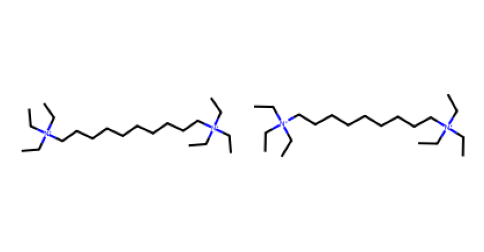

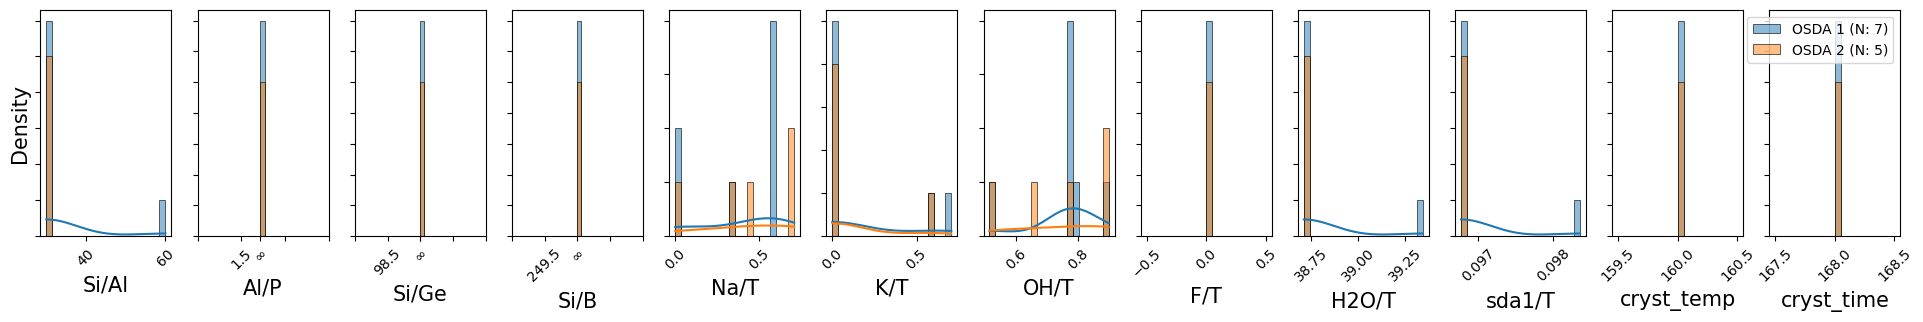

43
zeo: MFI
osda 1: CC[N+](CC)(CC)CCCCCCCCCC[N+](CC)(CC)CC 7
osda 2: CC[N+](CC)(CC)CCCCCCC[N+](CC)(CC)CC 4
osda similarity: 1.0
synthesis similarity: 0.99951154


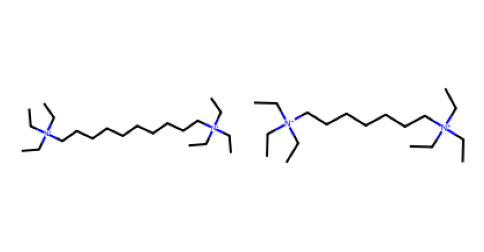

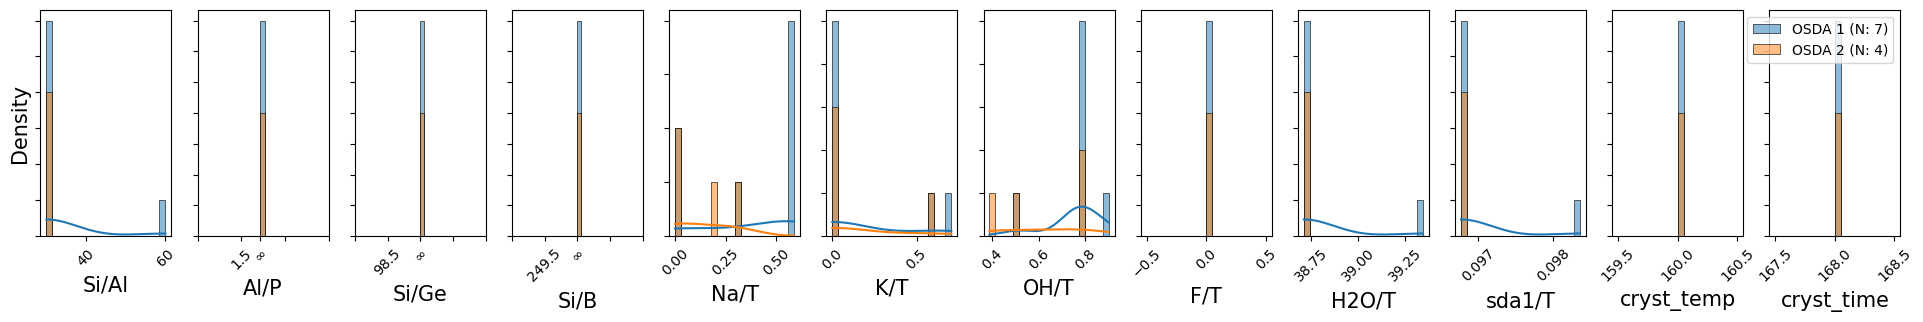

44
zeo: ANA
osda 1: CC[N+](CC)(CC)CCCCCCCC[N+](CC)(CC)CC 1
osda 2: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 1
osda similarity: 1.0
synthesis similarity: 1.0


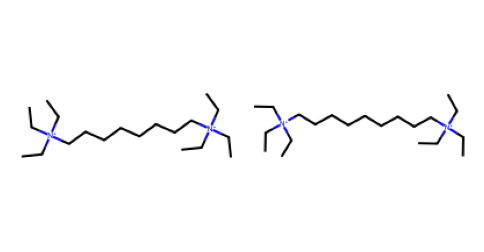

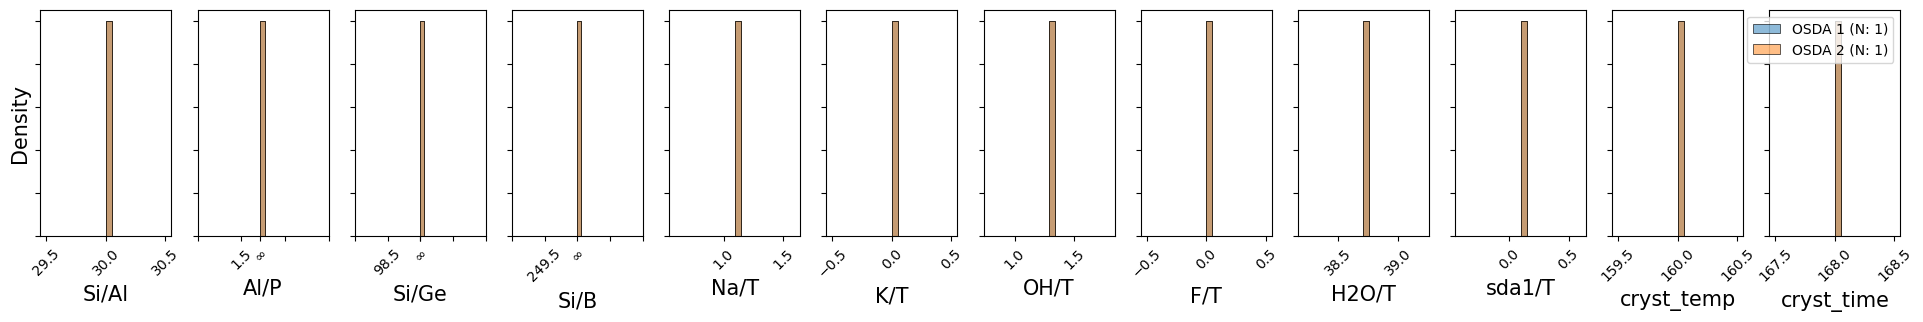

45
zeo: STF
osda 1: CC[N+]1(C)C(C)CCCC1C 5
osda 2: CC[N+]1(C)[C@@H](C)CCC[C@H]1C 1
osda similarity: 1.0
synthesis similarity: 0.39754388


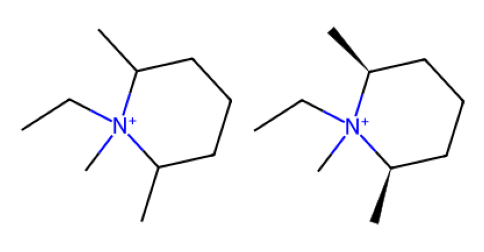

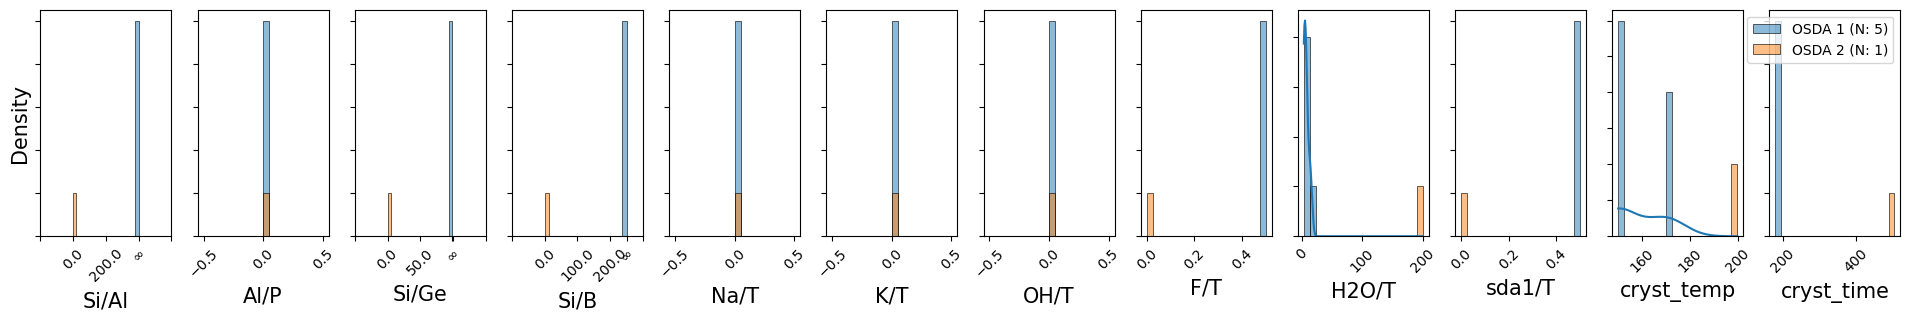

46
zeo: ANA
osda 1: CC[N+](CC)(CC)CCCCCCC[N+](CC)(CC)CC 1
osda 2: CC[N+](CC)(CC)CCCCCCCCC[N+](CC)(CC)CC 1
osda similarity: 1.0
synthesis similarity: 1.0


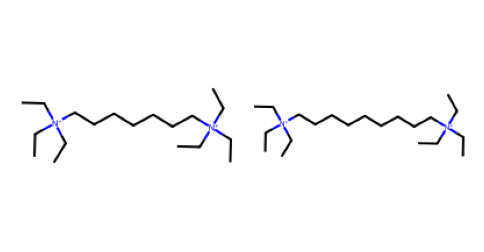

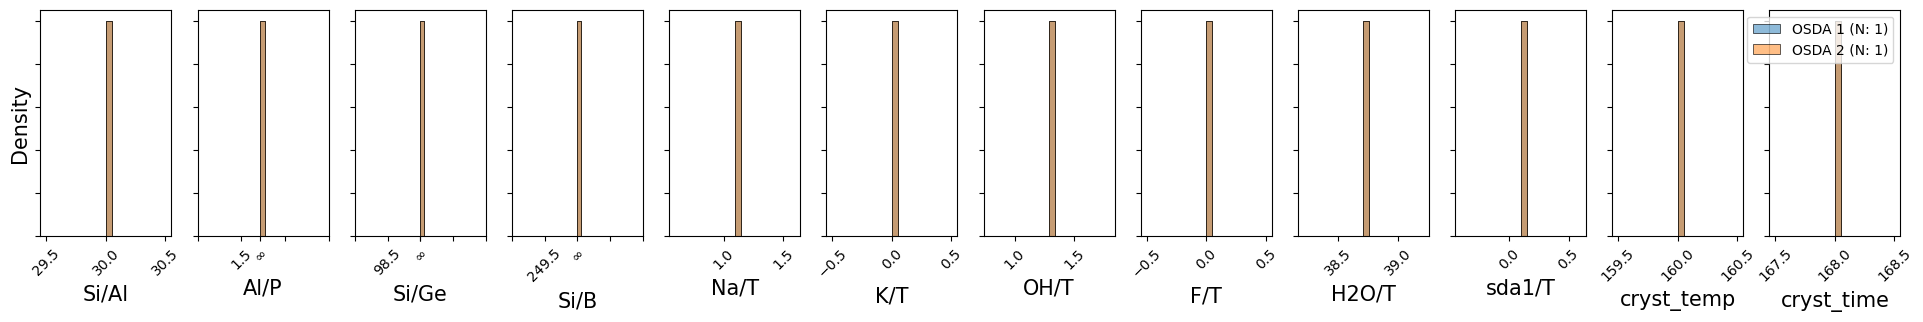

47
zeo: MFI
osda 1: CC1CC(C)C[N+](C)(C)C1 2
osda 2: C[C@H]1C[C@H](C)C[N+](C)(C)C1 2
osda similarity: 1.0
synthesis similarity: 0.67066085


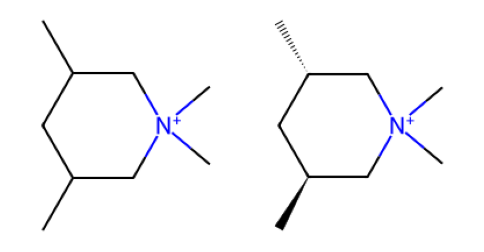

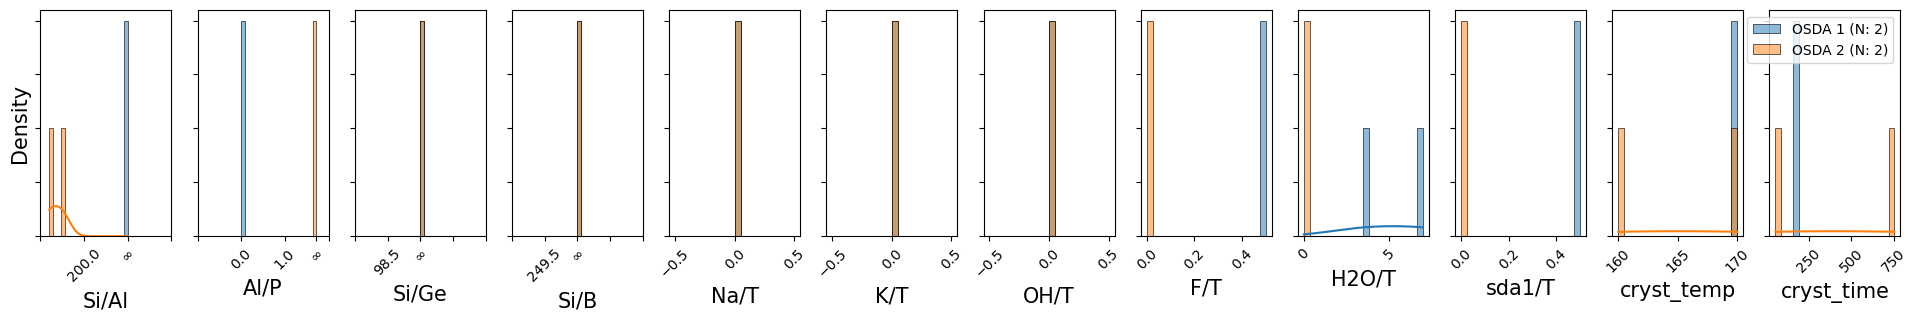

48
zeo: AEI
osda 1: C[C@H]1C[C@@H](C)C[N+](C)(C)C1 14
osda 2: C[C@H]1C[C@H](C)C[N+](C)(C)C1 1
osda similarity: 1.0
synthesis similarity: 0.9756538


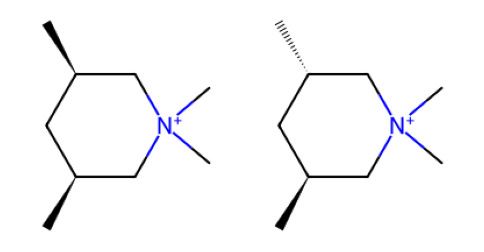

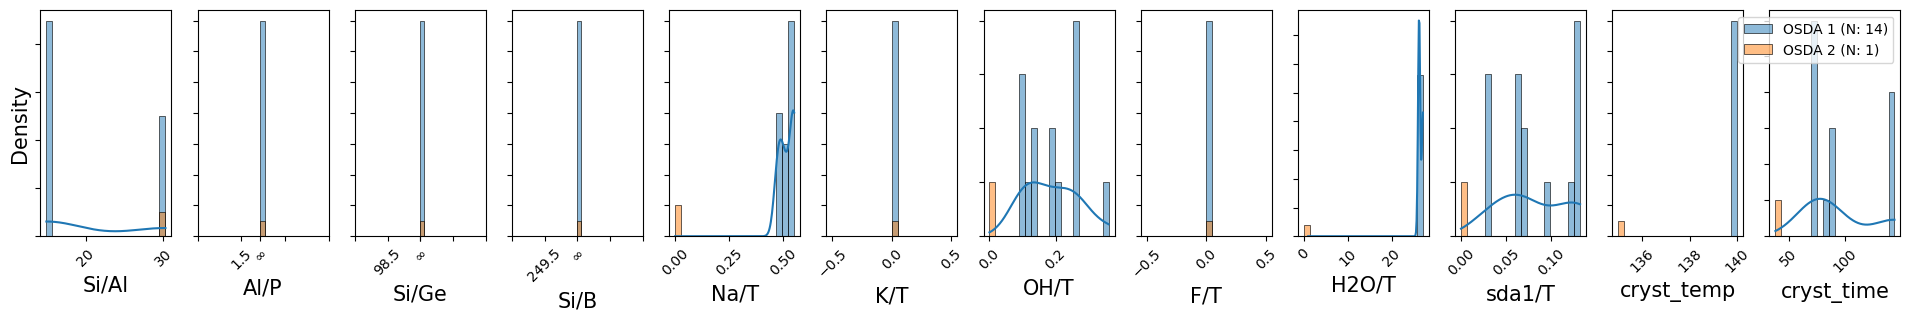

49
zeo: TON
osda 1: NCCCCCCCCCCCCN 7
osda 2: NCCCCCCCCCCN 1
osda similarity: 1.0
synthesis similarity: 0.9936379


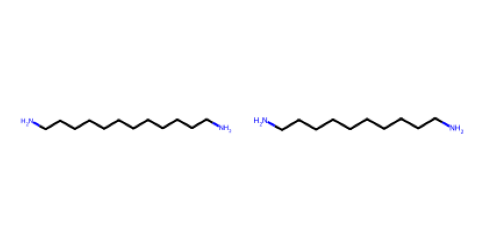

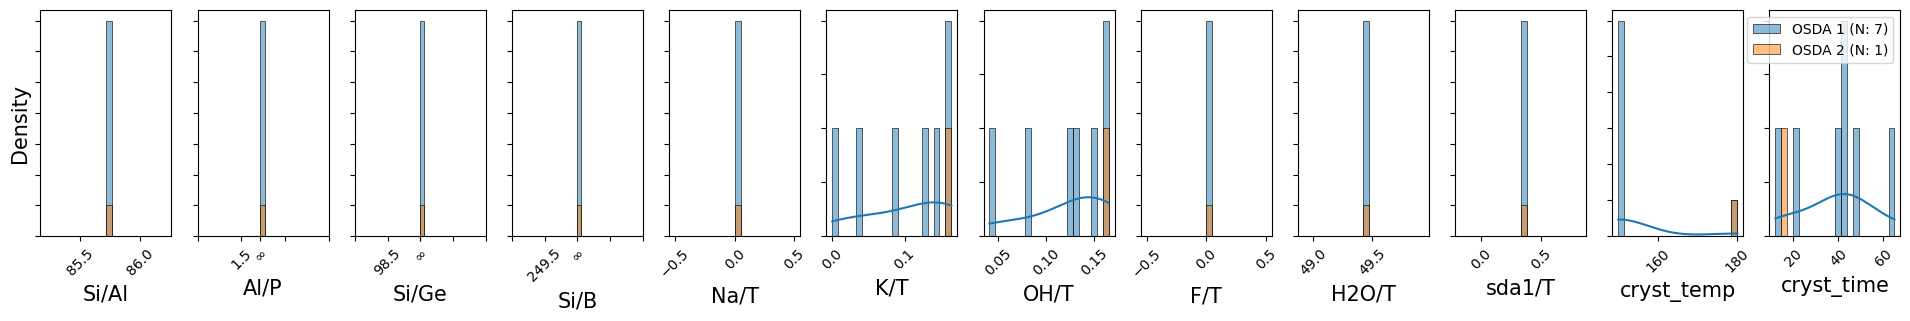

50
zeo: ANA
osda 1: C[N+](C)(C)CCCCCCC[N+](C)(C)C 1
osda 2: C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C 1
osda similarity: 1.0
synthesis similarity: 1.0


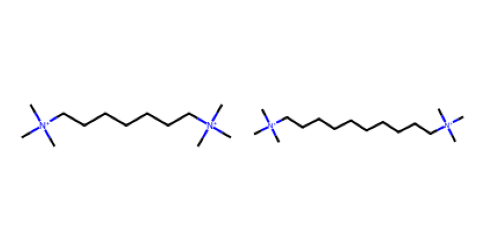

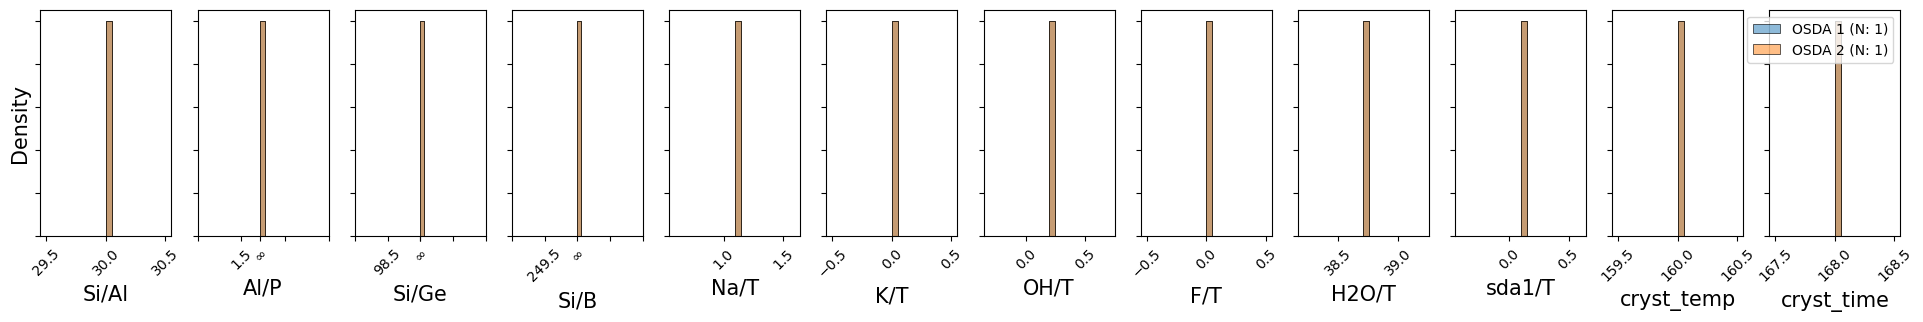

In [10]:
for idx in range(len(df_osda_sim.sort_values('osda_sim', ascending=False))):
    data = df_osda_sim.sort_values('osda_sim', ascending=False).iloc[idx]
    zeo, osda_src, osda_ref, osda_sim, syn_sim = data['zeo'], data['osda_src'], data['osda_ref'], data['osda_sim'], data['syn_sim']

    df_zeo = df[df['zeo']==zeo]
    df_zeo = df_zeo.drop(columns=['zeo'])

    df_zeo_osda_src = df_zeo[df_zeo['osda']==osda_src].drop(columns=['osda'])
    df_zeo_osda_ref = df_zeo[df_zeo['osda']==osda_ref].drop(columns=['osda']) 

    print(idx)
    print('zeo:', zeo)
    print('osda 1:', osda_src, len(df_zeo_osda_src))
    print('osda 2:', osda_ref, len(df_zeo_osda_ref))
    print('osda similarity:', osda_sim)
    print('synthesis similarity:', syn_sim)
    
    visualize_smiles([osda_src, osda_ref])
    compare_gel_conds(df_zeo_osda_src, df_zeo_osda_ref, kde=True)

    if idx == 50:
        break


In [11]:
 df[(df['zeo']=='FER') & (df['osda']=='C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C')]

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
22296,45.0,1.717997,99.0,250.0,0.097826,0.0,0.391304,0.0,39.130432,0.195652,180.0,144.0,FER,C[N+](C)(C)CCCCCCCCCCCCCC[N+](C)(C)C


In [12]:
 df[(df['zeo']=='FER') & (df['osda']=='C[N+](C)(C)CCCCCCCCCCCCCCCC[N+](C)(C)C')]

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
22297,45.0,1.717997,99.0,250.0,0.097826,0.0,0.391304,0.0,39.130432,0.195652,180.0,240.0,FER,C[N+](C)(C)CCCCCCCCCCCCCCCC[N+](C)(C)C


In [13]:
 df[(df['zeo']=='EMT') & (df['osda']=='C1COCCOCCOCCOCCO1')]

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
17649,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17650,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17651,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17652,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17653,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17654,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17655,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17656,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17657,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1
17658,5.0,1.717997,99.0,250.0,0.35,0.0,0.28,0.0,8.333333,0.041667,110.0,192.0,EMT,C1COCCOCCOCCOCCO1


# Zeolite-OSDA similarity

In [14]:
# unique_zeo_osda = list(df[['zeo', 'osda']].value_counts().keys())

# zeo_sims, osda_sims, syn_sims = [], [], []
# zeo_refs, osda_refs, zeo_srcs, osda_srcs = [], [], [], []

# for ref_idx in tqdm.tqdm(range(len(unique_zeo_osda))):

#     zeo_ref, osda_ref = unique_zeo_osda[ref_idx] # Reference zeo-OSDA

#     if (zeo_ref != 'Dense/Amorphous') and (osda_ref != 'OSDA-free'):
#         df_zeo_osda_ref = df[(df['zeo']==zeo_ref) & (df['osda']==osda_ref)].drop(columns=['zeo', 'osda'])

#         for src_idx in range(ref_idx):  # Lower triangular matrix WITHOUT diagonal (diagonal is self-similarity, which is not useful)
            
#             zeo_src, osda_src = unique_zeo_osda[src_idx] # Source zeo-OSDA

#             if (zeo_src != 'Dense/Amorphous') and (osda_src != 'OSDA-free'):
#                 df_zeo_osda_src = df[(df['zeo']==zeo_src) & (df['osda']==osda_src)].drop(columns=['zeo', 'osda'])

#                 # 1) ZEOLITE SIMILARITY
#                 zeo_sim = get_zeolite_similarity(zeo_src, zeo_ref)

#                 # 2) OSDA SIMILARITY
#                 osda_sim = calculate_tanimoto_similarity(osda_src, osda_ref, plot=False) # compare to refence OSDA

#                 # 3) SYNTHESIS SIMILARITY
#                 syn_sim = cosine_similarity(df_zeo_osda_src.values, df_zeo_osda_ref.values) # n_samples_X, n_samples_Y
#                 syn_sim = syn_sim.mean() # scalar

#                 zeo_sims.append(zeo_sim), osda_sims.append(osda_sim), syn_sims.append(syn_sim)
#                 zeo_refs.append(zeo_ref), osda_refs.append(osda_ref), zeo_srcs.append(zeo_src), osda_srcs.append(osda_src)

In [15]:
# df_zeo_osda_sim = pd.DataFrame({'zeo_ref': zeo_refs, 'osda_ref': osda_refs, 'zeo_src': zeo_srcs, 'osda_src': osda_srcs, 'zeo_sim': zeo_sims, 'osda_sim': osda_sims, 'syn_sim': syn_sims})
# df_zeo_osda_sim.to_csv('zeo_osda_sim-v2.csv')

In [16]:
# import matplotlib as mpl
# mpl.rcParams['agg.path.chunksize'] = 1000
# plt.figure(figsize=(6.5,5),dpi=100)
# plt.hexbin(df_zeo_osda_sim['zeo_sim'], df_zeo_osda_sim['syn_sim'], gridsize=30, bins='log', cmap='inferno')
# ax = plt.gca()
# ax.set_facecolor('black')
# plt.xlabel('Zeolite similarity')
# plt.ylabel('Synthesis MMD dissimilarity')
# plt.show()